<a href="https://colab.research.google.com/github/esxmod/PUBG-Finish-Placement-Prediction/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PUBG Finish Placement Prediction

https://www.kaggle.com/competitions/pubg-finish-placement-prediction    

## 문제 정의

    Can you predict the battle royale finish of PUBG Players?


Kaggle에서 주어진 PUBG의 플레이어 데이터들을 기반으로 해당 플레이어의 최종 등수를 예측하는 것이 목적이다.

## 가설

데이터 분석에 앞서 등수 예측에 영향을 줄 것으로 추정되는 컬럼들을 선별하여 가설을 세워 본다.  
이후 각 가설에 대하여 EDA 를 통해 검증을 진행한다.

아래는 가설들에 대한 정의이며 이와 같이 역할을 분담하였다.

    박**
    - 무조건 킬을 많이 한다고 등수에 영향이 있을까?

    임**
    - 높은 등수를 차지하는 데에는 존버가 유리할까 여포가 유리할까?

    손**
    - 힐, 부스트 사용 횟수에 따라 생존율에 영향을 끼칠 것이다.

    성**
    - 아이템(무기, 치료 아이템, 부스터 등)을 많이 획득할 수록 생존 확률이 높을 것이다.

    박**
    - 레이트 지표(랭크 티어)는 등수와 크게 관련이 없을 것 같다.

## 라이브러리 및 데이터 로드

### 라이브러리 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 사용자 정의 함수

각 컬럼 내 데이터의 범위를 확인하여 최적의 데이터 타입을 찾아 메모리 낭비를 줄여준다.

사용할 때 아래 두가지를 유의해야 한다.
- 실수 자료형의 경우 `float16` 으로 줄일 경우 데이터 손실이 일어난다.
- 문자열의 경우 Id, groupId, matchId 값들로 인해 `category` 타입으로 변환하면 오히려 메모리가 증가한다.

출처: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

In [ ]:
def reduce_mem_usage(df):
  start_mem = df.memory_usage().sum() / 1024**2

  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)  
      else:
        # if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
        #   df[col] = df[col].astype(np.float16)
        # el
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)
    # else:
    #   df[col] = df[col].astype('category')

  end_mem = df.memory_usage().sum() / 1024**2
  print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'
    .format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))

  return df

### 설정

In [ ]:
import gc
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set()

pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

DATASET_ROOT = '/content/drive/MyDrive/Project/Modeling/pubg-finish-placement-prediction'
TRAIN_PATH = DATASET_ROOT + '/train_V2.csv'
TEST_PATH = DATASET_ROOT + '/test_V2.csv'

### 데이터 로드 및 확인

In [ ]:
!ls '{DATASET_ROOT}'

sample_submission_V2.csv  test_V2.csv  train_V2.csv


In [ ]:
train = pd.read_csv(TRAIN_PATH)
train = reduce_mem_usage(train)

print(train.shape)

Memory usage of dataframe is 983.90 MB --> 339.28 MB (Decreased by 65.5%)
(4446966, 29)


In [ ]:
train.head()

Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  kills  \
0        0.000      0              0      0         60        1241      0   
1       91.470      0              0      0         57           0      0   
2       68.000      0              0      0         47           0      0   
3       32.900      0              0      0         75           0      0   
4      100.000      0              0      0         45           0      1   

   killStreaks  longestKill  matchDuration  matchType  maxPlace  numGroups  \
0            0        0.000           1306  squad-fpp        28         26   
1            0        0.000           1777  squad-fpp        26         25   
2            0        0.000           1318        duo        50         47   
3            0        0.000           1436  squad-fpp        31         30   
4            1       58.530           1424   solo-fpp        97         95   

   rankPoints  revives  rideDistance  roadKills  swimDistance  teamKills  \
0          -1        0         0.000          0         0.000          0   
1        1484        0         0.004          0        11.040          0   
2        1491        0         0.000          0         0.000          0   
3        1408        0         0.000          0         0.000          0   
4        1560        0         0.000          0         0.000          0   

   vehicleDestroys  walkDistance  weaponsAcquired  winPoints  winPlacePerc  
0                0       244.800                1       1466         0.444  
1                0      1434.000                5          0         0.640  
2                0       161.800                2          0         0.775  
3                0       202.700                3          0         0.167  
4                0        49.750                2          0         0.188

### 데이터 타입 확인

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float32
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float32
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float32
 21  roadKills        int8   
 22  swimDistance     float32
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float32
 26  weaponsAcquired  int16  
 27  winPoints   

### 컬럼별 정보

- https://www.kaggle.com/competitions/pubg-finish-placement-prediction/data
- https://github.com/5quad/5quad.github.io/blob/master/_posts/2019-11-29-AIXProject.md#data-fieldscolumn

컬럼|설명
---------|-----------
DBNOs(Down But Not Out) | 적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
assists | 아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
boosts | 부스트 아이템 사용 횟수
damageDealt | 총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
headshotKills | 헤드샷 킬 수
heals | 힐링 아이템 사용 횟수
Id  | 플레이어 ID
killPlace | 매치에서의 킬 횟수 순위
killPoints  | 킬 수로 산정한 ELO의 개념. 만약 `rankPoints`에 -1 이외의 값이 있다면, `killPoints`의 0값은 값이 없는 것으로 처리됨
killStreaks  | 짧은 시간동안 최대한 많이 킬했을 때의 킬 수
kills | 총 킬 수
longestKill | 킬과 킬 사이의 이동한 가장 긴 거리
matchDuration  | 매치의 시간 (초 단위)
matchId  | 매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
matchType  | 매치 타입 `solo`, `duo`, `squad`, `solo-fpp`, `duo-fpp`, `squad-fpp`, 나머지는 이벤트 또는 커스텀 매치
rankPoints  | 랭킹 ELO의 개념
revives  | 아군 부활 횟수
rideDistance | 탈것으로 이동한 총 거리
roadKills  | 탈것으로 킬한 횟수
swimDistance | 수영한 총 거리
teamKills  | 팀킬 횟수
vehicleDestroys  | 차량 폭파 횟수
walkDistance | 걸어간 총 거리
weaponsAcquired | 얻은 무기의 수
winPoints  | 승리 횟수로 판단한 ELO의 개념
groupId  |  매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 새로운 그룹 아이디가 부여됨
numGroups  | 게임 내 총 그룹 수 (`solo` -> `duo` -> `squad`로 갈 수록 줄어듦)
maxPlace | 매치 내에서 최악의 등수
**winPlacePerc** | **예측 목표, 1에 가까워질 수록 순위가 높아진다. (0부터 1까지의 값으로 나타냄. 1은 1등을, 0은 꼴등을 의미)**

아래는 임**님이 정리해주신 내용

![image](https://cdn.discordapp.com/attachments/982182023705817192/983656633706115072/unknown.png)

## 공통 사항

### 결측치 확인 및 처리

In [ ]:
null_count = train.isnull().sum()
null_count[null_count > 0]

winPlacePerc    1
dtype: int64

In [ ]:
train.dropna(inplace=True)

## 데이터 분석 (EDA)

train 데이터는 별도의 전처리를 할 예정이므로 EDA 용 복사본을 생성한다.

In [ ]:
t = train.copy()

### 기초 통계량

In [ ]:
desc = t.describe()[1:].T
desc

mean      std     min      25%      50%      75%       max
assists            0.234    0.589   0.000    0.000    0.000    0.000    22.000
boosts             1.107    1.716   0.000    0.000    0.000    2.000    33.000
damageDealt      130.633  169.887   0.000    0.000   84.240  186.000  6616.000
DBNOs              0.658    1.146   0.000    0.000    0.000    1.000    53.000
headshotKills      0.227    0.602   0.000    0.000    0.000    0.000    64.000
heals              1.370    2.680   0.000    0.000    0.000    2.000    80.000
killPlace         47.599   27.463   1.000   24.000   47.000   71.000   101.000
killPoints       505.006  627.505   0.000    0.000    0.000 1172.000  2170.000
kills              0.925    1.558   0.000    0.000    0.000    1.000    72.000
killStreaks        0.544    0.711   0.000    0.000    0.000    1.000    20.000
longestKill       22.993   51.476   0.000    0.000    0.000   21.320  1094.000
matchDuration   1579.507  258.739 133.000 1367.000 1438.000 1851.000  2237.000
maxPlace          44.505   23.828   2.000   28.000   30.000   49.000   100.000
numGroups         43.008   23.289   1.000   27.000   30.000   47.000   100.000
rankPoints       892.010  736.648  -1.000   -1.000 1443.000 1500.000  5910.000
revives            0.165    0.472   0.000    0.000    0.000    0.000    39.000
rideDistance     606.092 1496.471   0.000    0.000    0.000    0.191 40710.000
roadKills          0.003    0.073   0.000    0.000    0.000    0.000    18.000
swimDistance       4.509   30.238   0.000    0.000    0.000    0.000  3823.000
teamKills          0.024    0.167   0.000    0.000    0.000    0.000    12.000
vehicleDestroys    0.008    0.093   0.000    0.000    0.000    0.000     5.000
walkDistance    1148.517 1180.553   0.000  155.100  685.600 1976.000 25780.000
weaponsAcquired    3.660    2.457   0.000    2.000    3.000    5.000   236.000
winPoints        606.460  739.700   0.000    0.000    0.000 1495.000  2013.000
winPlacePerc       0.473    0.307   0.000    0.200    0.458    0.741     1.000

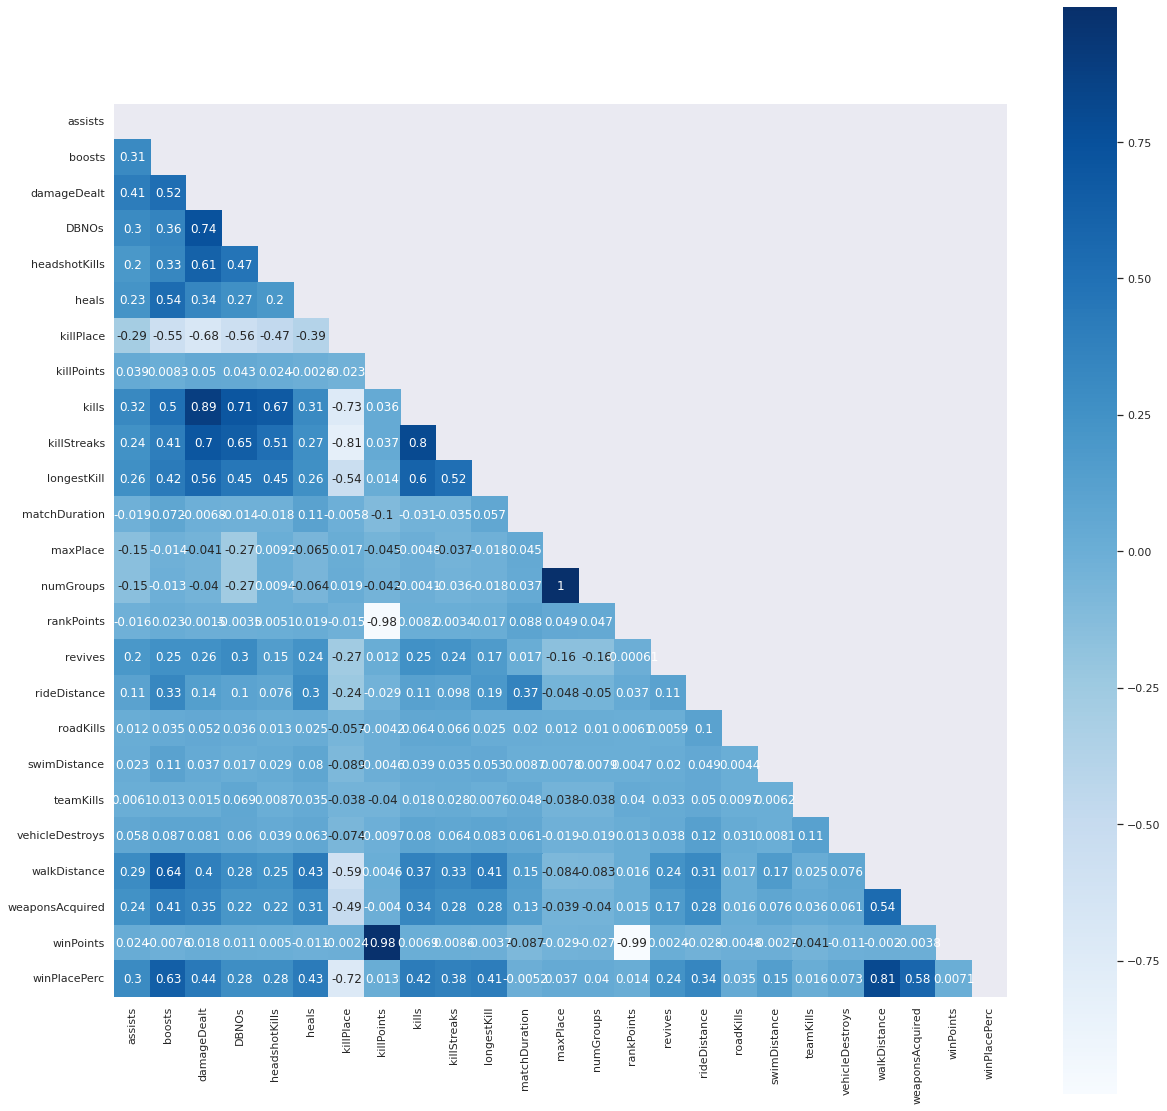

In [ ]:
corr = t.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20, 20))
sns.heatmap(data=corr, mask=mask, square=True, cmap="Blues", annot=True)
plt.show()

### 가설 검증) 레이트 지표는 등수와 관련이 있을까?

레이트 지표는 아래 3가지로 나뉜다.
- killPoints
- rankPoints
- winPoints

이 중에서는 흔히 게임에서 볼 수 있는 랭크시스템에 대한 지표인 rankPoints 를 주로 다룰 것이다.

#### matchType 분류

rankPoints 는 사실상 랭크전의 경우에 한해서만 의미가 있는 지표이다.  
그러므로 matchType 별로 랭크전만 따로 분류할 필요가 있다.

- 랭크전: solo, solo-fpp, duo, duo-fpp, squad, squad-fpp
- 일반전: normal-solo, normal-solo-fpp, normal-duo, normal-duo-fpp, normal-squad, normal-squad-fpp
- 이벤트전: crashtpp, crashfpp, flaretpp, flarefpp

tpp, fpp 는 각각 3인칭과 1인칭 모드를 의미한다.  

In [ ]:
rankType = ['solo-tpp', 'solo-fpp', 'duo-tpp', 'duo-fpp', 'squad-tpp', 'squad-fpp']
normalType = ['normal-solo-tpp', 'normal-solo-fpp', 'normal-duo-tpp', 'normal-duo-fpp', 'normal-squad-tpp', 'normal-squad-fpp']
eventType = ['crash-tpp', 'crash-fpp', 'flare-tpp', 'flare-fpp']
matchType2 = ['rank', 'normal', 'event']
matchType3 = ['solo', 'duo', 'squad']
viewType = ['tpp', 'fpp']

def preprocess_matchType(df):
  df.loc[df['matchType'] == 'solo', 'matchType'] = 'solo-tpp'
  df.loc[df['matchType'] == 'duo', 'matchType'] = 'duo-tpp'
  df.loc[df['matchType'] == 'squad', 'matchType'] = 'squad-tpp'
  df.loc[df['matchType'] == 'normal-solo', 'matchType'] = 'normal-solo-tpp'
  df.loc[df['matchType'] == 'normal-duo', 'matchType'] = 'normal-duo-tpp'
  df.loc[df['matchType'] == 'normal-squad', 'matchType'] = 'normal-squad-tpp'
  df.loc[df['matchType'] == 'crashtpp', 'matchType'] = 'crash-tpp'
  df.loc[df['matchType'] == 'crashfpp', 'matchType'] = 'crash-fpp'
  df.loc[df['matchType'] == 'flaretpp', 'matchType'] = 'flare-tpp'
  df.loc[df['matchType'] == 'flarefpp', 'matchType'] = 'flare-fpp'

  df.loc[df['matchType'].apply(lambda x: x in rankType), 'matchType2'] = 'rank'
  df.loc[df['matchType'].apply(lambda x: x in normalType), 'matchType2'] = 'normal'
  df.loc[df['matchType'].apply(lambda x: x in eventType), 'matchType2'] = 'event'

  df.loc[df['matchType'].apply(lambda x: x.find('solo') >= 0), 'matchType3'] = 'solo'
  df.loc[df['matchType'].apply(lambda x: x.find('duo') >= 0), 'matchType3'] = 'duo'
  df.loc[df['matchType'].apply(lambda x: x.find('squad') >= 0), 'matchType3'] = 'squad'
  df.loc[df['matchType'].apply(lambda x: x.find('crash') >= 0), 'matchType3'] = 'crash'
  df.loc[df['matchType'].apply(lambda x: x.find('flare') >= 0), 'matchType3'] = 'flare'

  df.loc[df['matchType'].apply(lambda x: x.find('tpp') >= 0), 'viewType'] = 'tpp'
  df.loc[df['matchType'].apply(lambda x: x.find('fpp') >= 0), 'viewType'] = 'fpp'

  return df

In [ ]:
t = preprocess_matchType(t)

In [ ]:
t.groupby(['viewType', 'matchType2', 'matchType3']).size()

viewType  matchType2  matchType3
fpp       event       crash            6287
                      flare             718
          normal      duo              5489
                      solo             1682
                      squad           17174
          rank        duo            996691
                      solo           536761
                      squad         1756186
tpp       event       crash             371
                      flare            2505
          normal      duo               199
                      solo              326
                      squad             516
          rank        duo            313591
                      solo           181943
                      squad          626526
dtype: int64

In [ ]:
t = t[t['matchType2'] == 'rank']

#### rankPoints 분포 확인

0 부근에 상당히 많이 존재하고, 그 외 대부분은 1000 ~ 2000 사이에 분포하는 모습이다.

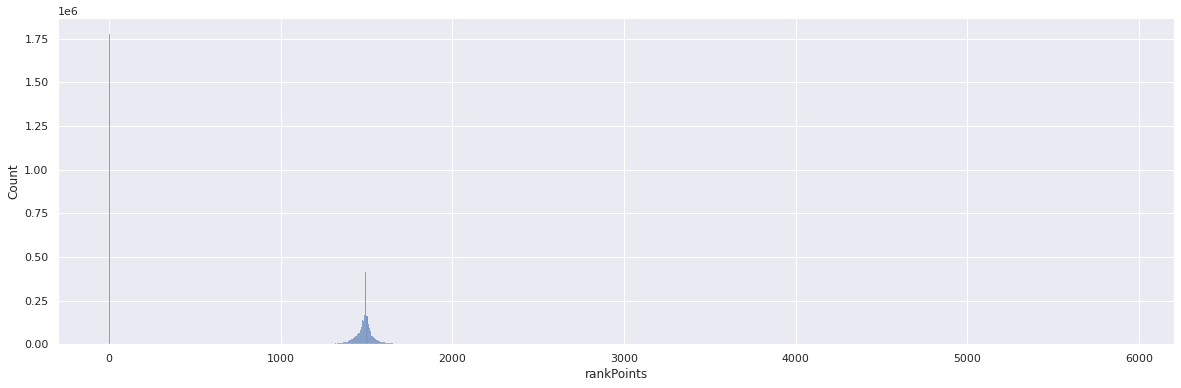

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=t, x='rankPoints', bins=1000)
plt.show()

가장 많이 분포하는 값은 다음과 같다.

In [ ]:
t.groupby('rankPoints').size().sort_values(ascending=False)[:5]

rankPoints
-1       1689596
 1500     277019
 0         89178
 1480      48857
 1494      42612
dtype: int64

#### rankPoints 가 -1 인 경우

Kaggle의 공식 설명에 따르면 해당 컬럼은 **API의 다음버전 부터 더 이상 사용되지 않는다**고 명시되어 있다.  
또한 해당 값이 `-1` 인 경우는 `None` 의 의미로 본다.

그러므로 이는 분석 대상에서 제외하고 진행하기로 한다.

In [ ]:
t = t[t['rankPoints'] != -1]

#### rankPoints 초기값 추측

다음으로 최빈값은 1500 이며 그 수는 277019 건이다.

In [ ]:
len(t[t['rankPoints'] == 1500])

277019

물론 1490 ~ 1499 구간의 비중도 비슷한 수이긴 하나 조금 의심이 된다.

In [ ]:
len(t[(t['rankPoints'] >= 1490) & (t['rankPoints'] < 1500)])

289400

어디까지나 예상이지만 랭크시스템은 최소 몇판을 진행한 뒤 평가를 받는 방식인데  
데이터상의 모든 플레이어가 조건을 만족 했으리라고 보진 않는다.  
그중에서는 첫판인 경우도 있을 것이고 이미 진행중인 경우도 있을 것이다.

즉, Unranked 상태가 존재하는데 이 경우 rankPoints 가 0 또는 1500 일 가능성이 높다.

그 중에선 1490 ~ 1499 구간의 비중도 높은것으로 보아 0 쪽이 유력해 보인다.  
마찬가지로 89178 명씩이나 고의로 패배를 해서 점수를 내릴 것으로 보이진 않기 때문이다.

In [ ]:
len(t[t['rankPoints'] == 0])

89178

만약 0 이 실제 평가가 반영된 점수라고 한다면 아래 범위의 값도 하나쯤은 존재해야 한다.

In [ ]:
len(t[(t['rankPoints'] > 0) & (t['rankPoints'] < 100)])

0

그러므로 0 의 경우를 Unranked 로 간주하여 이들을 분석 대상에서 제외하기로 한다.  

또한 1500 의 경우는 평가 진행 상태를 판단할 기준이 없으므로 그대로 두기로 한다.

In [ ]:
t = t[t['rankPoints'] != 0]

#### 정제된 rankPoints 분포 확인

이제 어느정도 제대로 분포된 데이터들을 살펴볼 수 있을 것이다.

In [ ]:
corr = t.corr()
desc = t.describe()[1:].T

In [ ]:
desc.loc[['rankPoints']]

mean    std     min      25%      50%      75%      max
rankPoints 1494.292 89.968 100.000 1465.000 1496.000 1513.000 5910.000

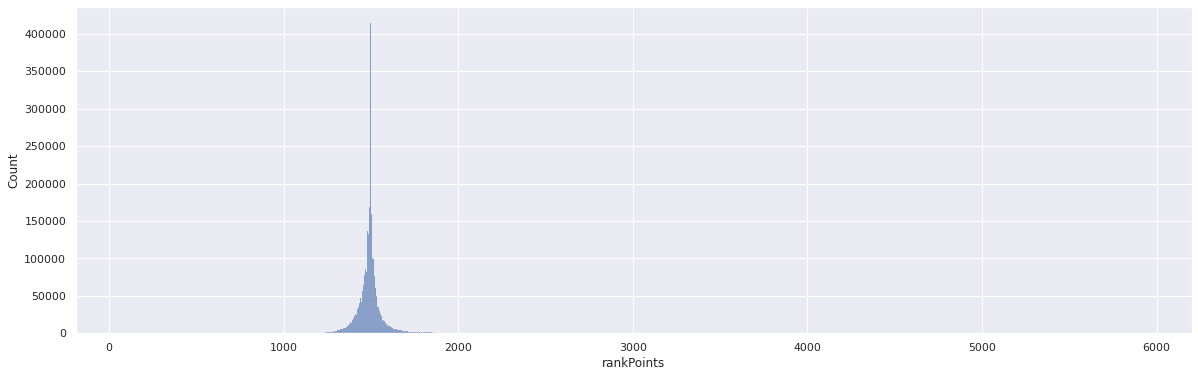

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=t, x='rankPoints', bins=1000)
plt.show()

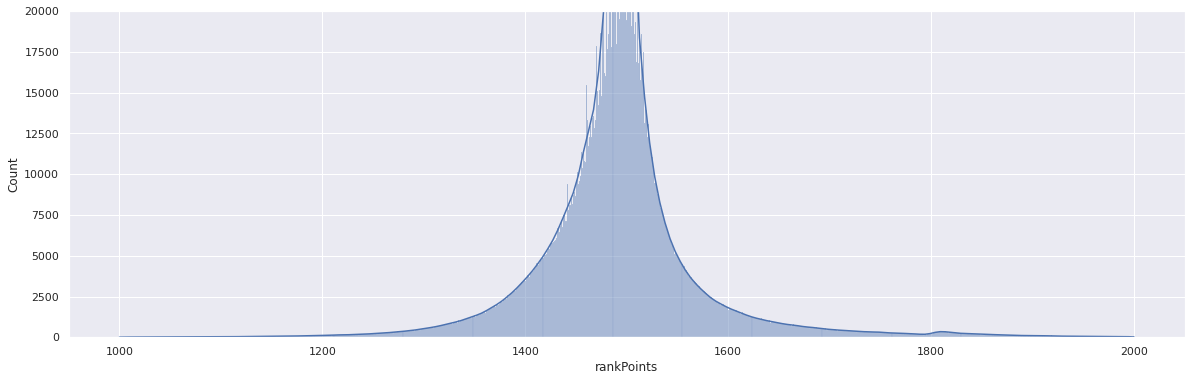

In [ ]:
cond = ((1000 <= t['rankPoints']) & (t['rankPoints'] <= 2000))

plt.figure(figsize=(20, 6))
sns.histplot(data=t[cond], x='rankPoints', bins=1000, kde=True)
plt.ylim(0, 20000)
plt.show()

#### rankPoints 티어별 세분화

위 분포의 모습은 전형적인 랭크시스템(티어)의 분포인데, 이를 더 자세히 보기 위해 티어별로 분류를 할 필요가 있어 보인다.

티어 정보는 아래에서 참고하였다.
- ~https://namu.wiki/w/PUBG:%20BATTLEGROUNDS/%EB%9E%AD%ED%81%AC#s-3.2~  

이는 시즌 7 (2020년 5월 20일) 이후의 자료인데 Kaggle 대회는 2018년 10월 5일 에 시작됬으므로 모순이 생긴다.  
그러므로 2018년 9월 20일에 작성된 아래 지표가 시기상 맞아 떨어진다.

- https://bbs.pubg.game.daum.net/gaia/do/pubg/update/read?articleId=751&objCate1=202&bbsId=PN001&pageIndex=1

In [ ]:
def tier_solver(x):
  if x < 1400: return 'Bronze'
  elif x < 1500: return 'Silver'
  elif x < 1600: return 'Gold'
  elif x < 1700: return 'Platinum'
  elif x < 1800: return 'Diamond'
  elif x < 1900: return 'Elite'
  elif x < 2000: return 'Master'
  return 'Grandmaster'

t['tier'] = t['rankPoints'].apply(tier_solver)

tiers = ['Bronze', 'Silver', 'Gold', 'Platinum', 'Diamond', 'Elite', 'Master', 'Grandmaster']

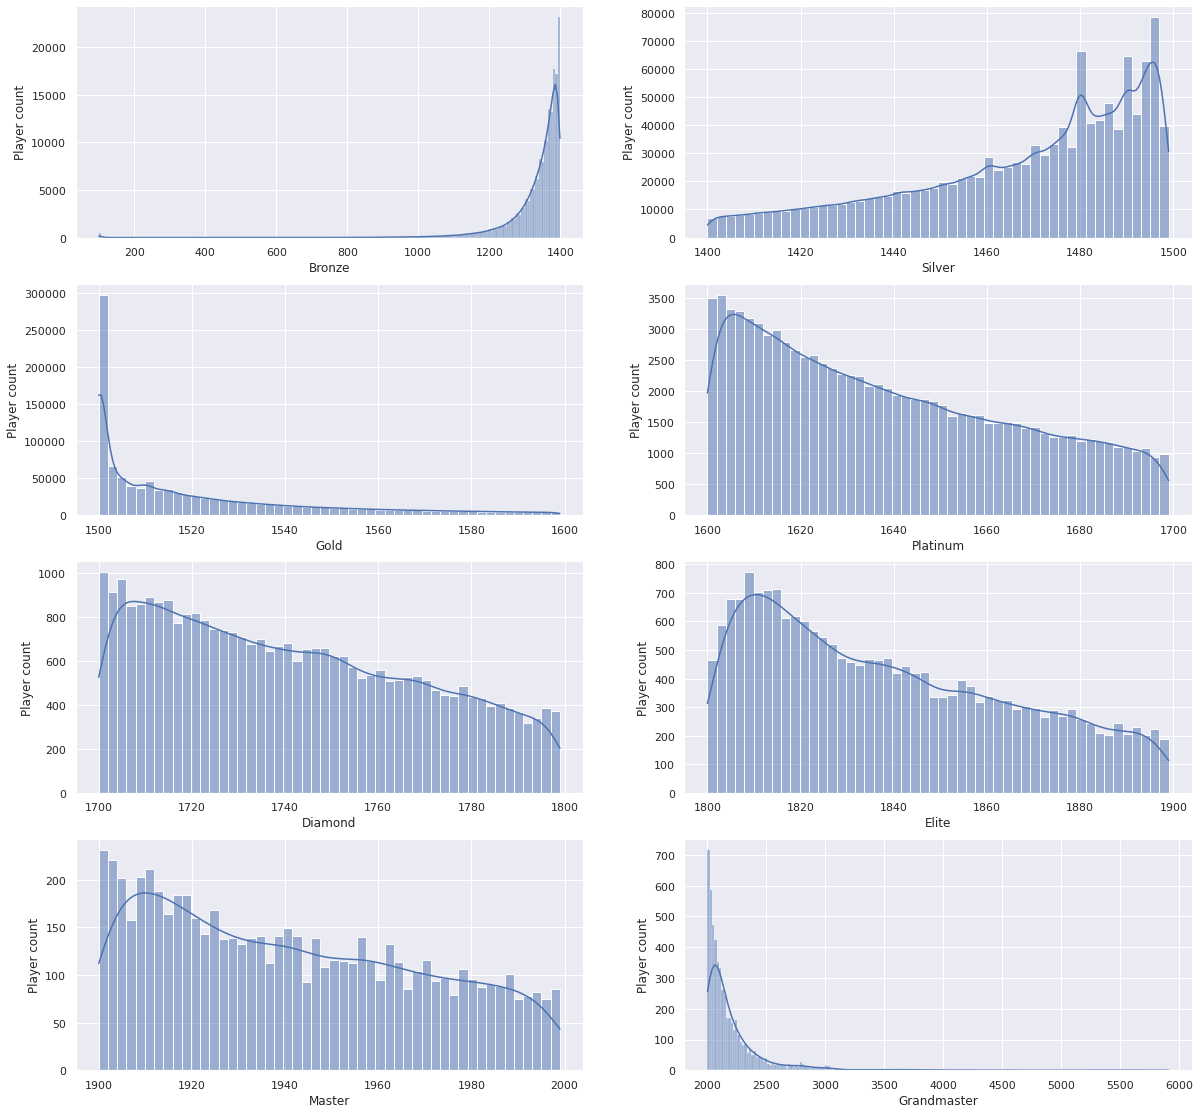

In [ ]:
bins = [200, 50, 50, 50, 50, 50, 50, 200]

fig = plt.figure(figsize=(20, 40))

for i, tier in enumerate(tiers):
  graph = fig.add_subplot(8, 2, i + 1)
  ax = sns.histplot(data=t[t['tier'] == tier], x='rankPoints', bins=bins[i], kde=True, ax=graph)
  ax.set_xlabel(tier)
  ax.set_ylabel('Player count')

plt.show()

#### 티어별 분석

여전히 1500 부근의 분포가 상당히 높게 나오므로 티어별로 세분화하여 분석해볼 필요가 있다.

In [ ]:
tier_table = t['tier'].value_counts()
tier_table

Silver         1222053
Gold           1060995
Bronze          189278
Platinum         97011
Diamond          31031
Elite            20582
Master            6467
Grandmaster       5507
Name: tier, dtype: int64

Master 대비 Grandmaster 의 비중이 있는 이유는 Master 가 1900 ~ 1999, Grandmaster 가 2000 ~ Inf (5910) 구간으로 범위가 넓기 때문이다.

(극한의 실골 분포)

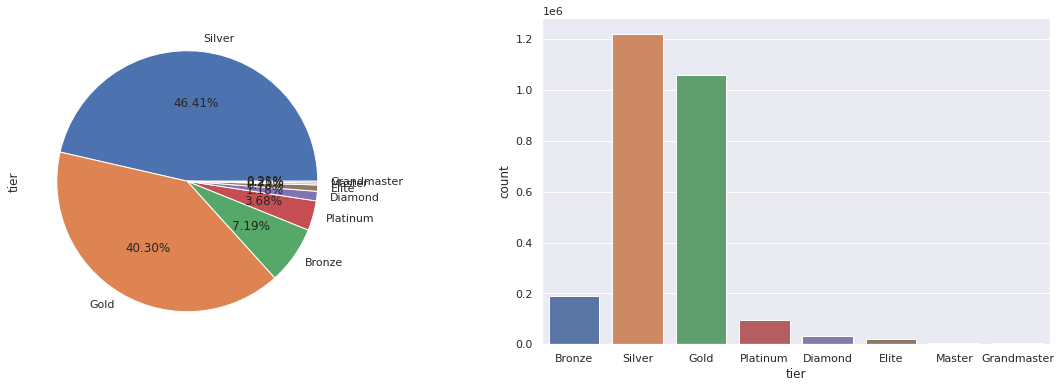

In [ ]:
fig = plt.figure(figsize=(20, 6))
graph1 = fig.add_subplot(1, 2, 1)
graph2 = fig.add_subplot(1, 2, 2)

tier_table.plot.pie(autopct='%1.2f%%', ax=graph1)
sns.countplot(data=t, x="tier", order=tiers, ax=graph2)
plt.show()

티어별로 나타낸 rankPoints 및 winPlacePerc 의 기초 통계량은 다음과 같다.

In [ ]:
aggs = {
    'rankPoints': [np.min, np.max, np.mean],
    'winPlacePerc': [np.min, np.max, np.mean],
}
t.groupby('tier').agg(aggs).sort_values(by=('rankPoints', 'amin'))

rankPoints                winPlacePerc            
                  amin  amax     mean         amin  amax  mean
tier                                                          
Bronze             100  1399 1333.123        0.000 1.000 0.391
Silver            1400  1499 1467.180        0.000 1.000 0.442
Gold              1500  1599 1520.658        0.000 1.000 0.501
Platinum          1600  1699 1638.831        0.000 1.000 0.602
Diamond           1700  1799 1741.262        0.000 1.000 0.639
Elite             1800  1899 1838.922        0.000 1.000 0.663
Master            1900  1999 1941.223        0.000 1.000 0.690
Grandmaster       2000  5910 2219.780        0.000 1.000 0.690

티어별로 winPlacePerc 의 분포를 확인해보면 대체로 높은 티어가 더 높은 평균 등수를 받는것으로 확인된다.

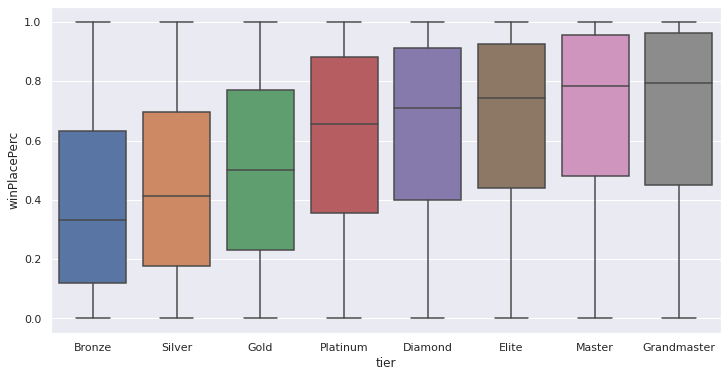

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=t, x='tier', y='winPlacePerc', order=tiers)
plt.show()

마찬가지로 우승 분포를 티어별로 살펴보면 티어가 높은 순으로 우승 비율이 높게 확인된다.

역으로 낮은 티어는 반대쪽에서 비율이 높게 확인된다.

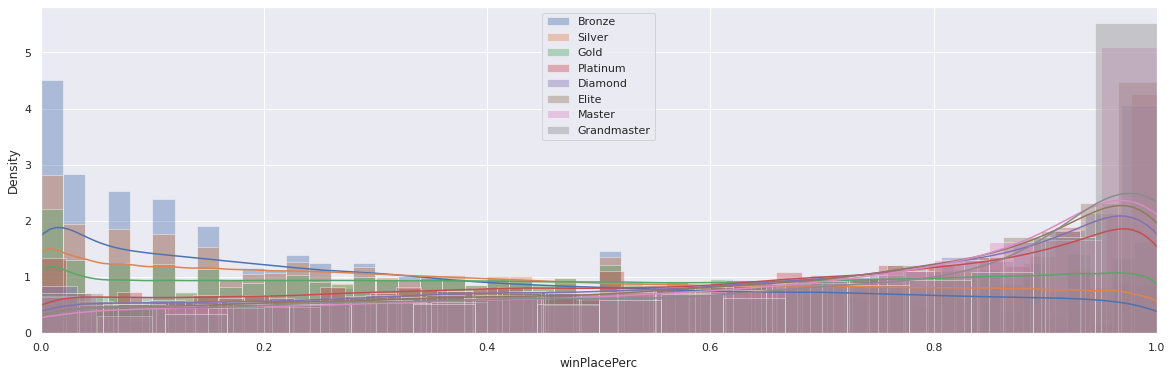

In [ ]:
plt.figure(figsize=(20, 6))
for tier in tiers:
  sns.distplot(t.loc[(t['tier'] == tier), 'winPlacePerc'], label=tier)
plt.legend()
plt.xlim(0, 1)
plt.show()

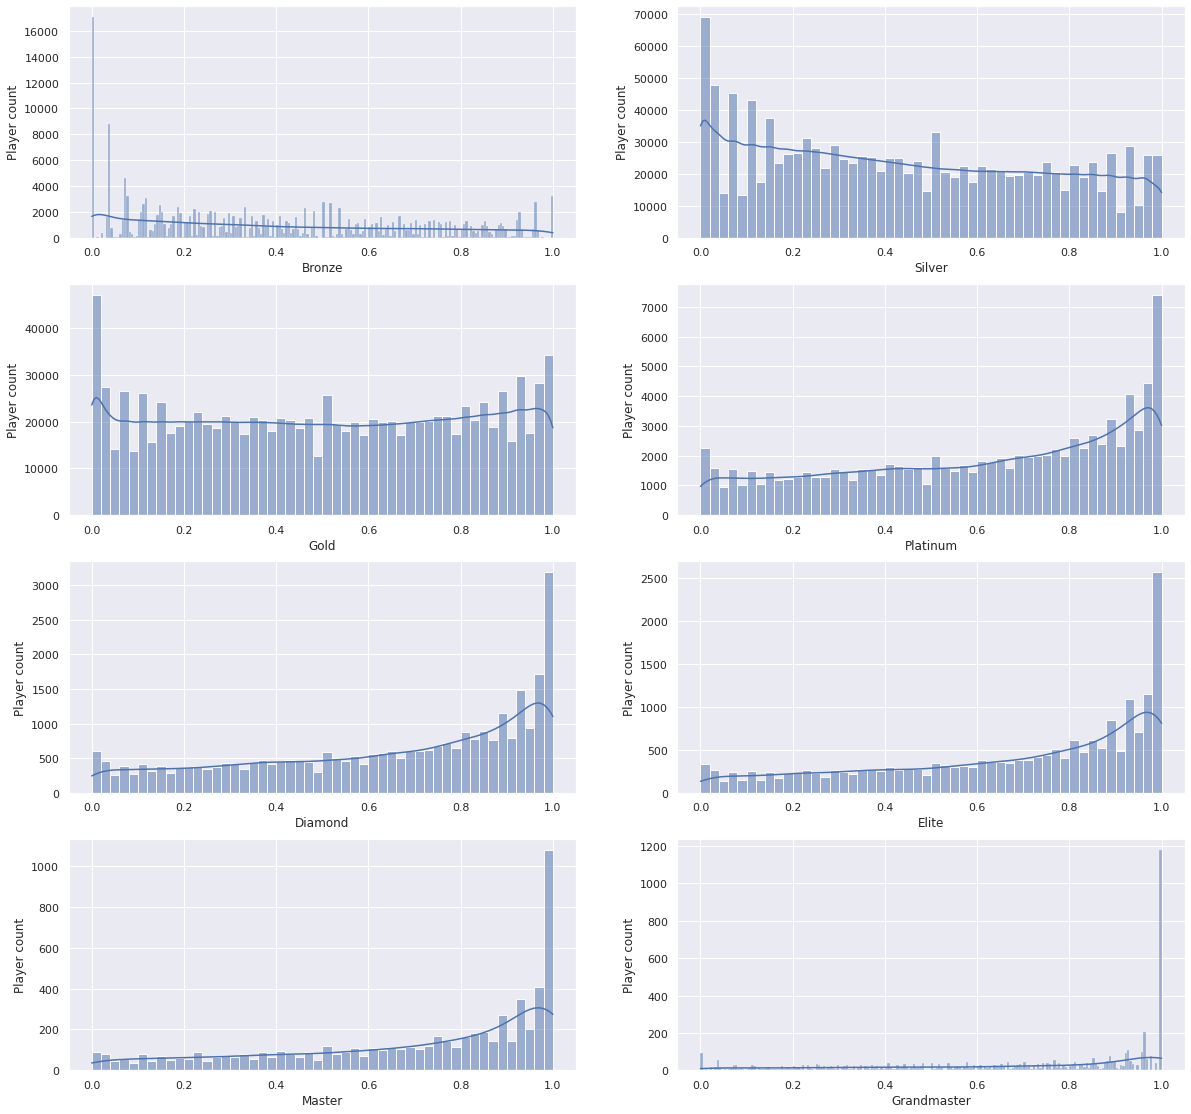

In [ ]:
fig = plt.figure(figsize=(20, 40))

for i, tier in enumerate(tiers):
  graph = fig.add_subplot(8, 2, i + 1)
  ax = sns.histplot(data=t[t['tier'] == tier], x='winPlacePerc', bins=bins[i], kde=True, ax=graph)
  ax.set_xlabel(tier)
  ax.set_ylabel('Player count')

plt.show()

상관계수를 살펴보면 다음과 같다.

In [ ]:
corr.loc['rankPoints', 'winPlacePerc']

0.1675371628844377

티어별로 각 상관계수를 살펴보면 다음과 같다.

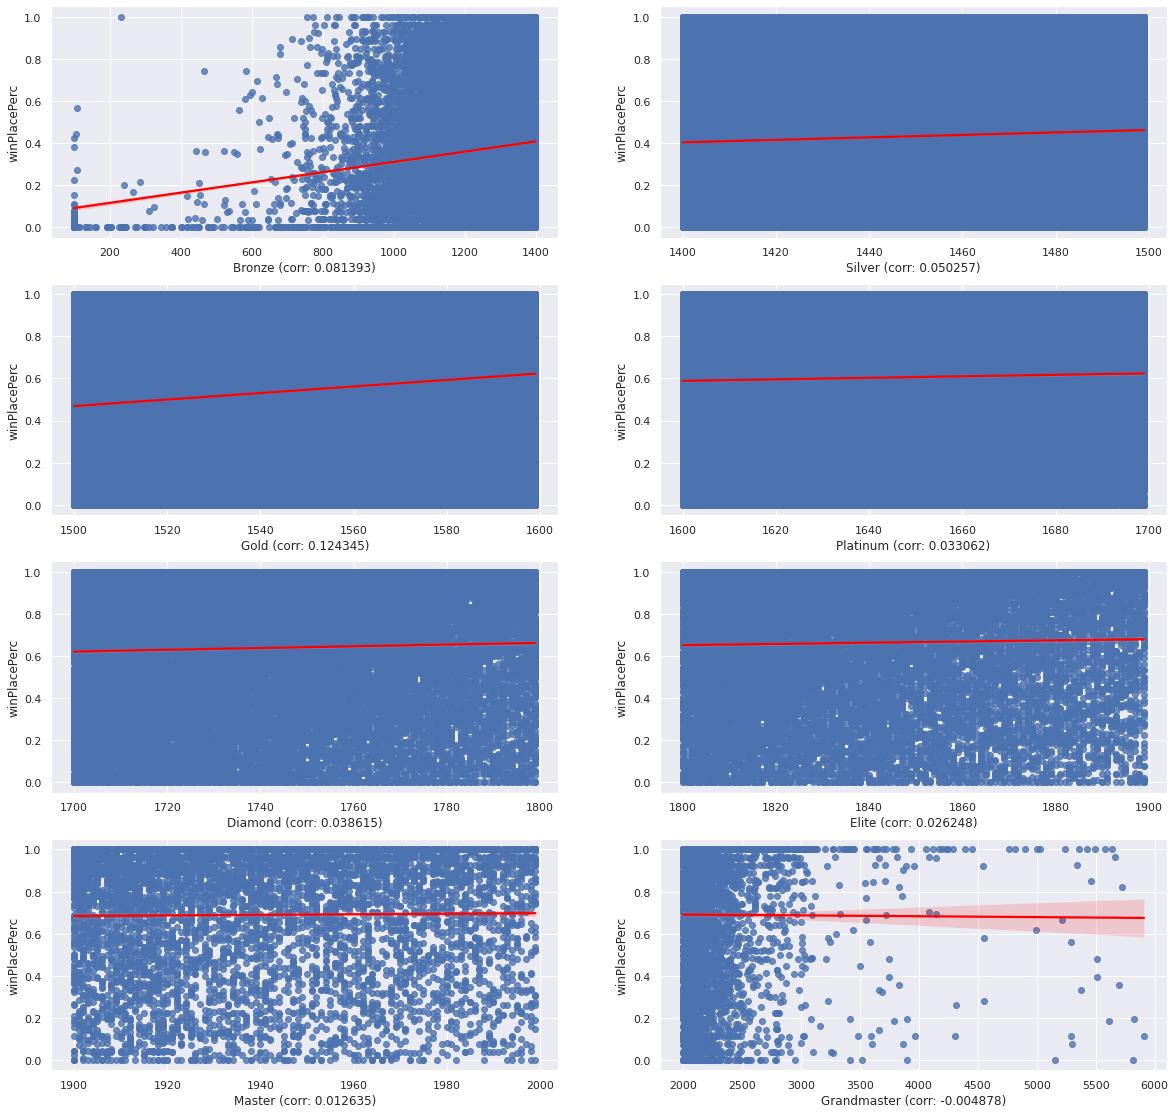

In [ ]:
fig = plt.figure(figsize=(20, 40))

for i, tier in enumerate(tiers):
  graph = fig.add_subplot(8, 2, i + 1)
  tmp = t[t['tier'] == tier]
  ax = sns.regplot(data=tmp, x='rankPoints', y='winPlacePerc', line_kws={'color': 'red'}, ax=graph)
  xlabel = '{} (corr: {:.6f})'.format(tier, tmp.corr().loc['rankPoints', 'winPlacePerc'])
  ax.set_xlabel(xlabel)

plt.show()

위의 histplot 분포와 달리 실제로 이들의 산점도를 그려보면 일부는 음수의 관계가 나타난다.

#### 티어별 킬 관련 지표 분석

rankPoints 와 winPlacePerc 만으로는 관계를 이해하기 힘드므로  
직관적으로 봐도 등수 예측과 가장 밀접한 관련이 있어보이는 킬, 데미지 관련 지표들과의 관계를 분석해보기로 한다.

이들은 다음과 같다.
- assists (솔로의 경우 제외)
- damageDealt
- DBNOs (솔로의 경우 제외)
- headshotKills
- killPlace
- kills
- killStreaks
- longestKill
- roadKills
- teamKills (솔로의 경우 제외)



팀플레이 지표를 제외한 이들의 상관계수는 rankPoints 와 비례하듯 winPlacePerc 와도 비슷한 비율이 나온다.

In [ ]:
corr.loc[['damageDealt', 'headshotKills', 'killPlace', 'kills', 'killStreaks', 'longestKill', 'roadKills'], ['rankPoints', 'winPlacePerc']]

rankPoints  winPlacePerc
damageDealt         0.159         0.451
headshotKills       0.104         0.285
killPlace          -0.147        -0.721
kills               0.154         0.434
killStreaks         0.111         0.381
longestKill         0.120         0.415
roadKills           0.014         0.034

티어가 오를 수록 킬 평균 또한 같이 상승하는 모습이 보인다.

In [ ]:
t.groupby('tier')['kills'].describe().sort_values('mean')

count  mean   std   min   25%   50%   75%    max
tier                                                              
Bronze       189278.000 0.699 1.222 0.000 0.000 0.000 1.000 22.000
Silver      1222053.000 0.792 1.332 0.000 0.000 0.000 1.000 22.000
Gold        1060995.000 0.960 1.546 0.000 0.000 0.000 1.000 25.000
Platinum      97011.000 1.560 2.071 0.000 0.000 1.000 2.000 25.000
Diamond       31031.000 1.787 2.232 0.000 0.000 1.000 3.000 22.000
Elite         20582.000 1.900 2.276 0.000 0.000 1.000 3.000 21.000
Master         6467.000 2.273 2.527 0.000 0.000 2.000 3.000 20.000
Grandmaster    5507.000 2.899 2.920 0.000 1.000 2.000 4.000 18.000

역시나 킬 수가 증가하면 등수 또한 비례하는 모습이 보인다.

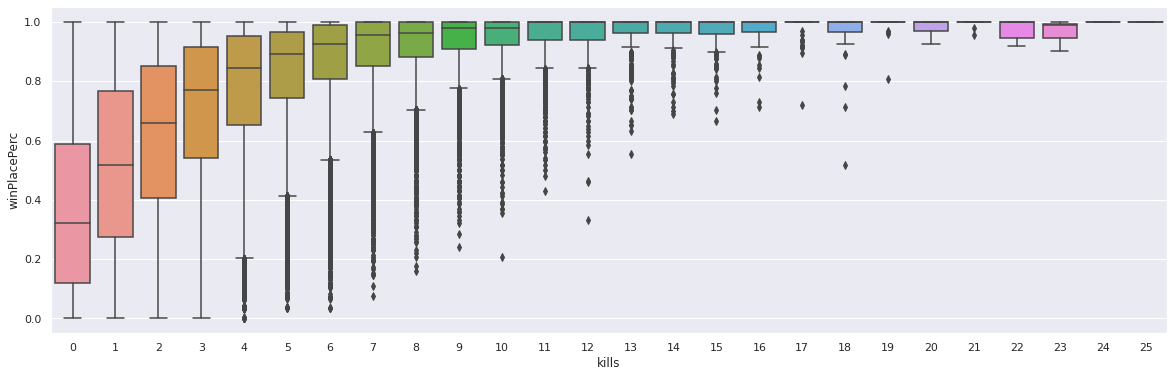

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t, x='kills', y='winPlacePerc')
plt.show()

하지만 rankPoints 가 증가하면 킬 수 또한 명확히 증가한다는 모습은 보이지 않는다.

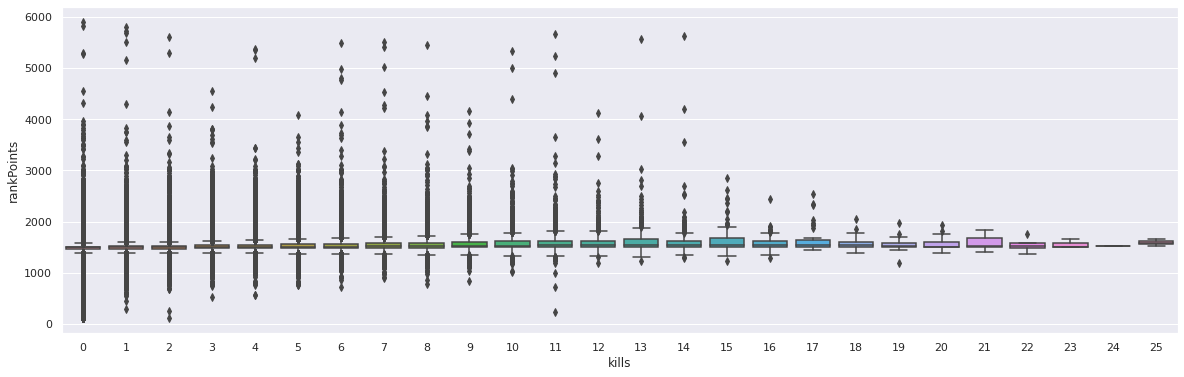

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t, x='kills', y='rankPoints')
plt.show()

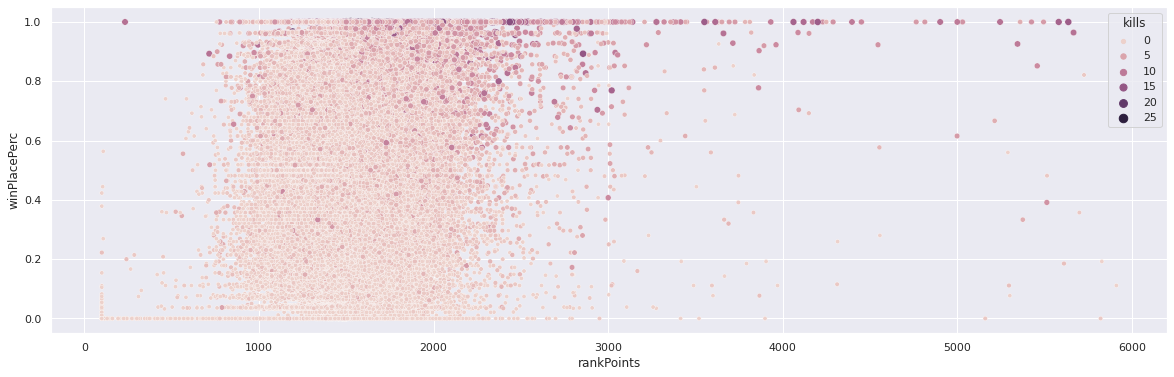

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=t, x='rankPoints', y='winPlacePerc', hue='kills', size='kills')
plt.show()

역시나 이상치들 때문에 분포 확인이 힘드므로 세분화 할 필요가 있어 보인다.

Bronze

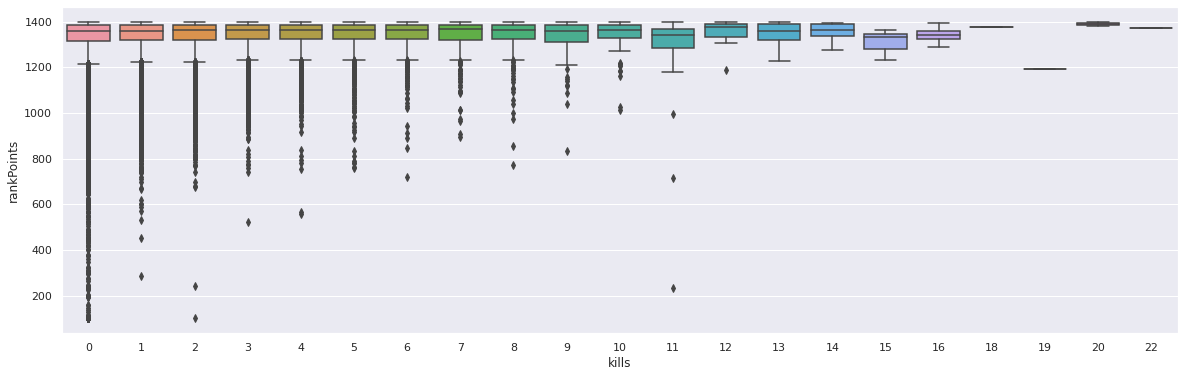

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t[t['tier'] == 'Bronze'], x='kills', y='rankPoints')
plt.show()

Silver

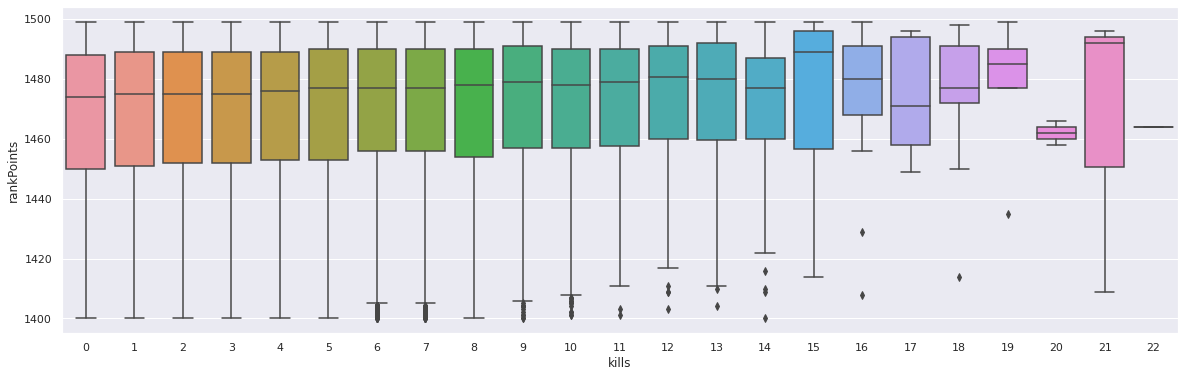

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t[t['tier'] == 'Silver'], x='kills', y='rankPoints')
plt.show()

Gold

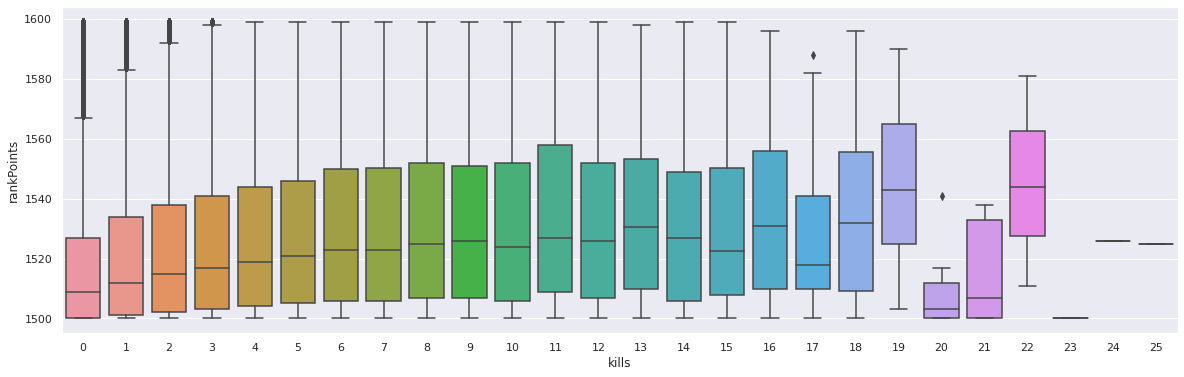

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t[t['tier'] == 'Gold'], x='kills', y='rankPoints')
plt.show()

Platinum

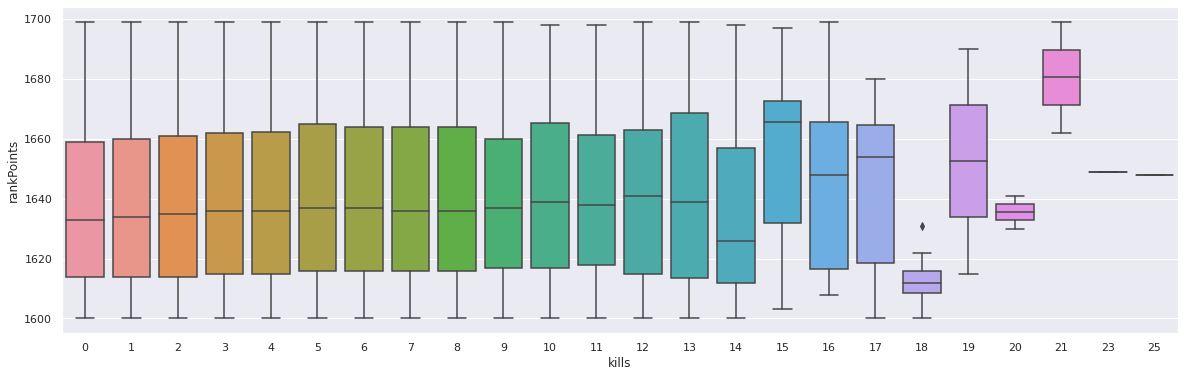

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t[t['tier'] == 'Platinum'], x='kills', y='rankPoints')
plt.show()

대체로 kill 수가 높을 수록 rankPoints 가 미세하게 높은 위치쪽으로 분포하는 경향이 보인다.

또한 티어별 킬수 대비 등수의 관계 또한 고티어일수록 동일 킬수 대비 높은 등수를 받는 경향도 보인다.  
그러나 이는 13킬이 넘어가는 이후부터는 비슷해지는 모습이다.

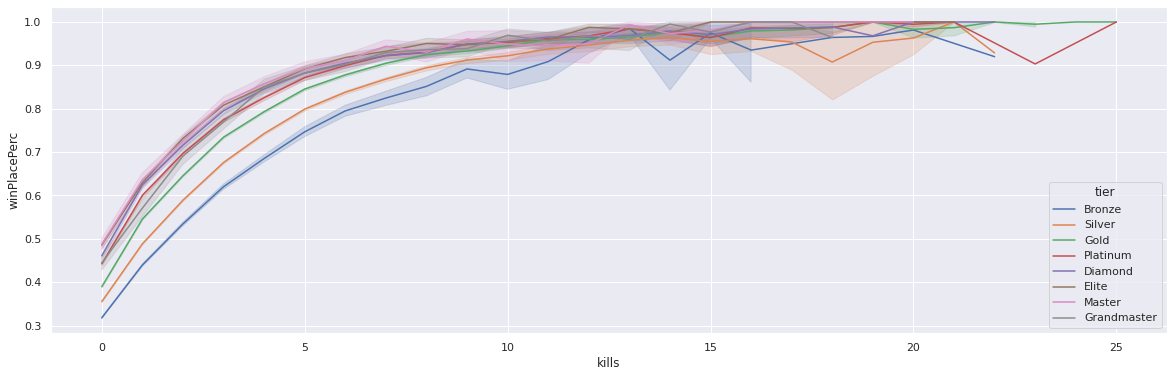

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=t, x='kills', y='winPlacePerc', hue='tier', hue_order=tiers)
plt.show()

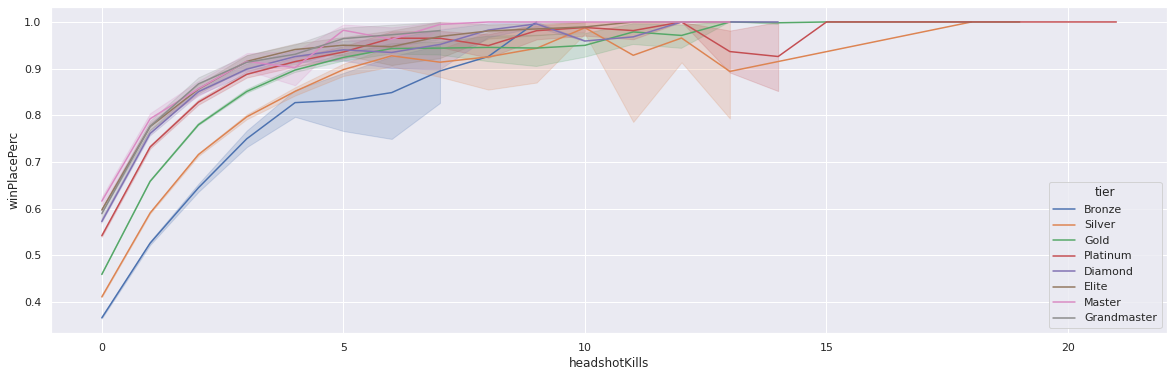

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=t, x='headshotKills', y='winPlacePerc', hue='tier', hue_order=tiers)
plt.show()

#### 팀 유무별 차이

대체로 인원수가 적은 순으로, 솔로인 경우는 부활 기회가 없는 이유로 생존률이 낮아 등수가 대체로 낮게 나오는 모습을 볼 수 있다.

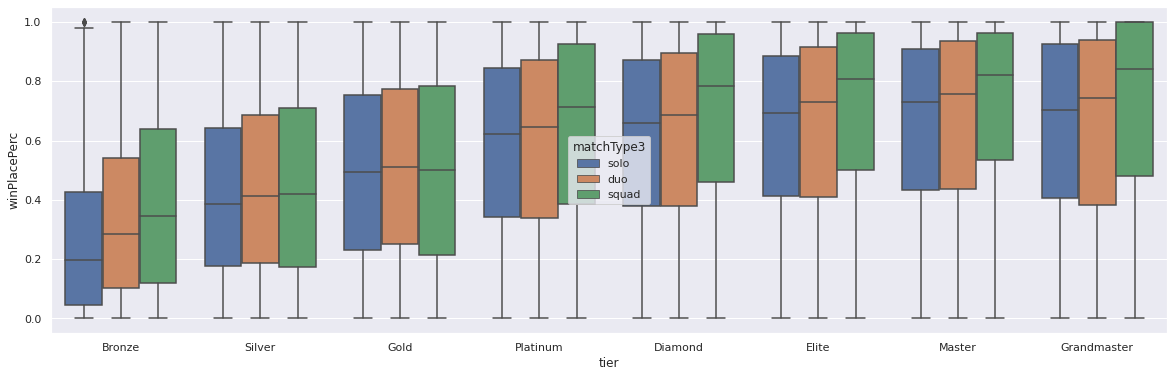

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=t, x='tier', y='winPlacePerc', order=tiers, hue='matchType3', hue_order=matchType3)
plt.show()

여담이지만 아래 점수대 이후부터는 솔로 플레이가 존재하지 않는다.

In [ ]:
t[(t['matchType3'] == 'solo') & (t['rankPoints'] >= 2860)]

Empty DataFrame
Columns: [Id, groupId, matchId, assists, boosts, damageDealt, DBNOs, headshotKills, heals, killPlace, killPoints, kills, killStreaks, longestKill, matchDuration, matchType, maxPlace, numGroups, rankPoints, revives, rideDistance, roadKills, swimDistance, teamKills, vehicleDestroys, walkDistance, weaponsAcquired, winPoints, winPlacePerc, matchType2, matchType3, viewType, tier]
Index: []

In [ ]:
t.groupby('matchType3')['kills'].describe().sort_values('mean')

count  mean   std   min   25%   50%   75%    max
matchType3                                                       
squad      1381864.000 0.902 1.491 0.000 0.000 0.000 1.000 25.000
solo        453034.000 0.913 1.488 0.000 0.000 0.000 1.000 23.000
duo         798026.000 0.921 1.511 0.000 0.000 0.000 1.000 22.000

아무래도 솔로 > 듀오 > 스쿼드 순으로 경쟁자가 많으므로 동일 킬수 대비 등수 비율 또한 비례한 모습이다.

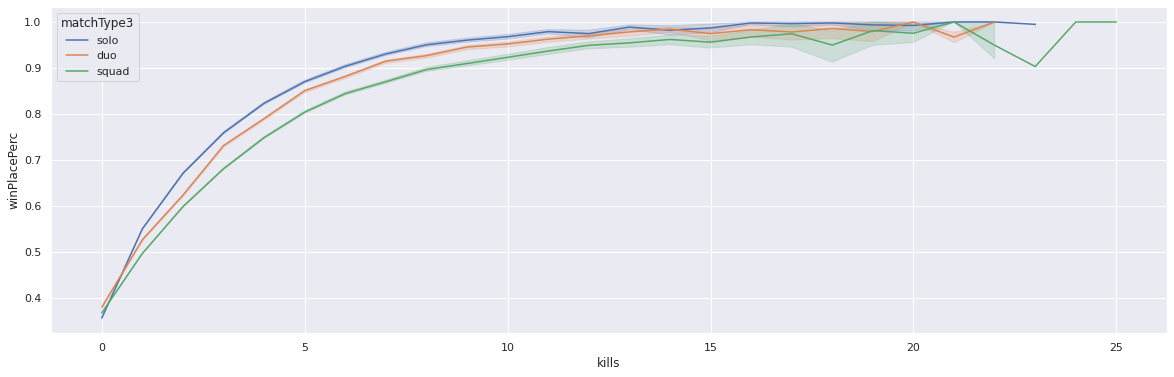

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=t, x='kills', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

Bronze, Silver 는 유난히 스쿼드가 많은것을 볼 수 있다.

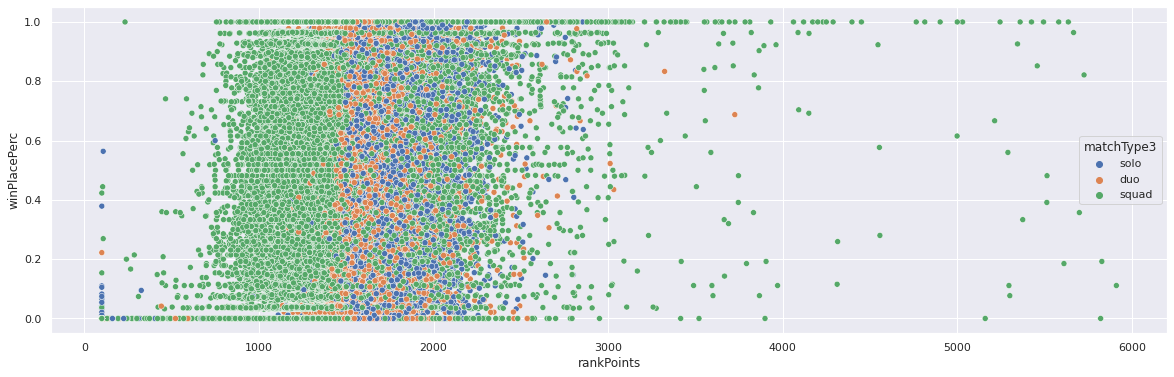

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=t, x='rankPoints', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


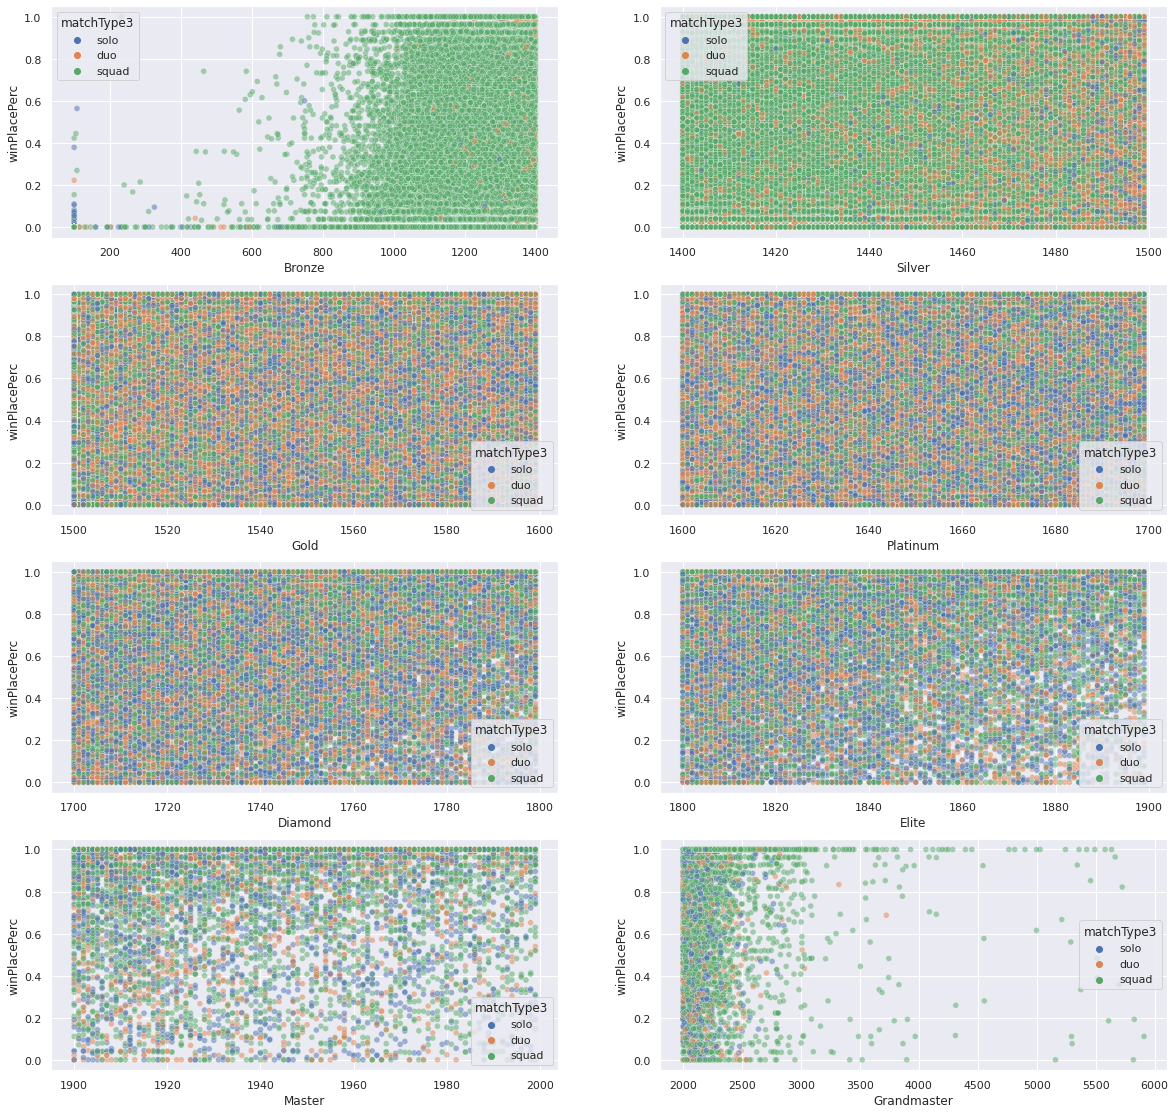

In [ ]:
fig = plt.figure(figsize=(20, 40))

for i, tier in enumerate(tiers):
  graph = fig.add_subplot(8, 2, i + 1)
  ax = sns.scatterplot(data=t[t['tier'] == tier], x='rankPoints', y='winPlacePerc', alpha=.5, hue='matchType3', hue_order=matchType3, ax=graph)
  ax.set_xlabel(tier)

plt.show()

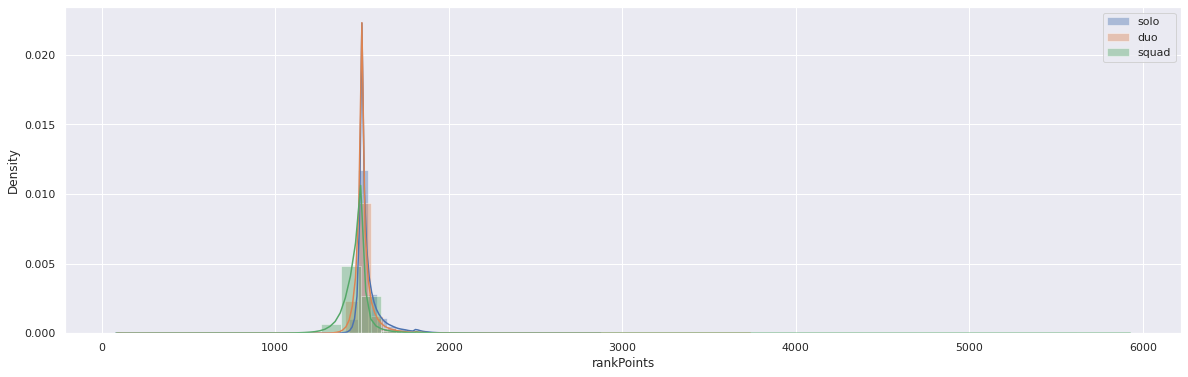

In [ ]:
plt.figure(figsize=(20, 6))
for matchType in matchType3:
  sns.distplot(t.loc[(t['matchType3'] == matchType), 'rankPoints'], label=matchType)
plt.legend()
plt.show()

또한 rankPoints 의 경우 티어별 분포를 다시 한번 매치 타입별로 살펴본 결과  
비중이 높은 Bronze, Silver 쪽의 rankPoints 분포가 다른 모습을 확인할 수 있다.

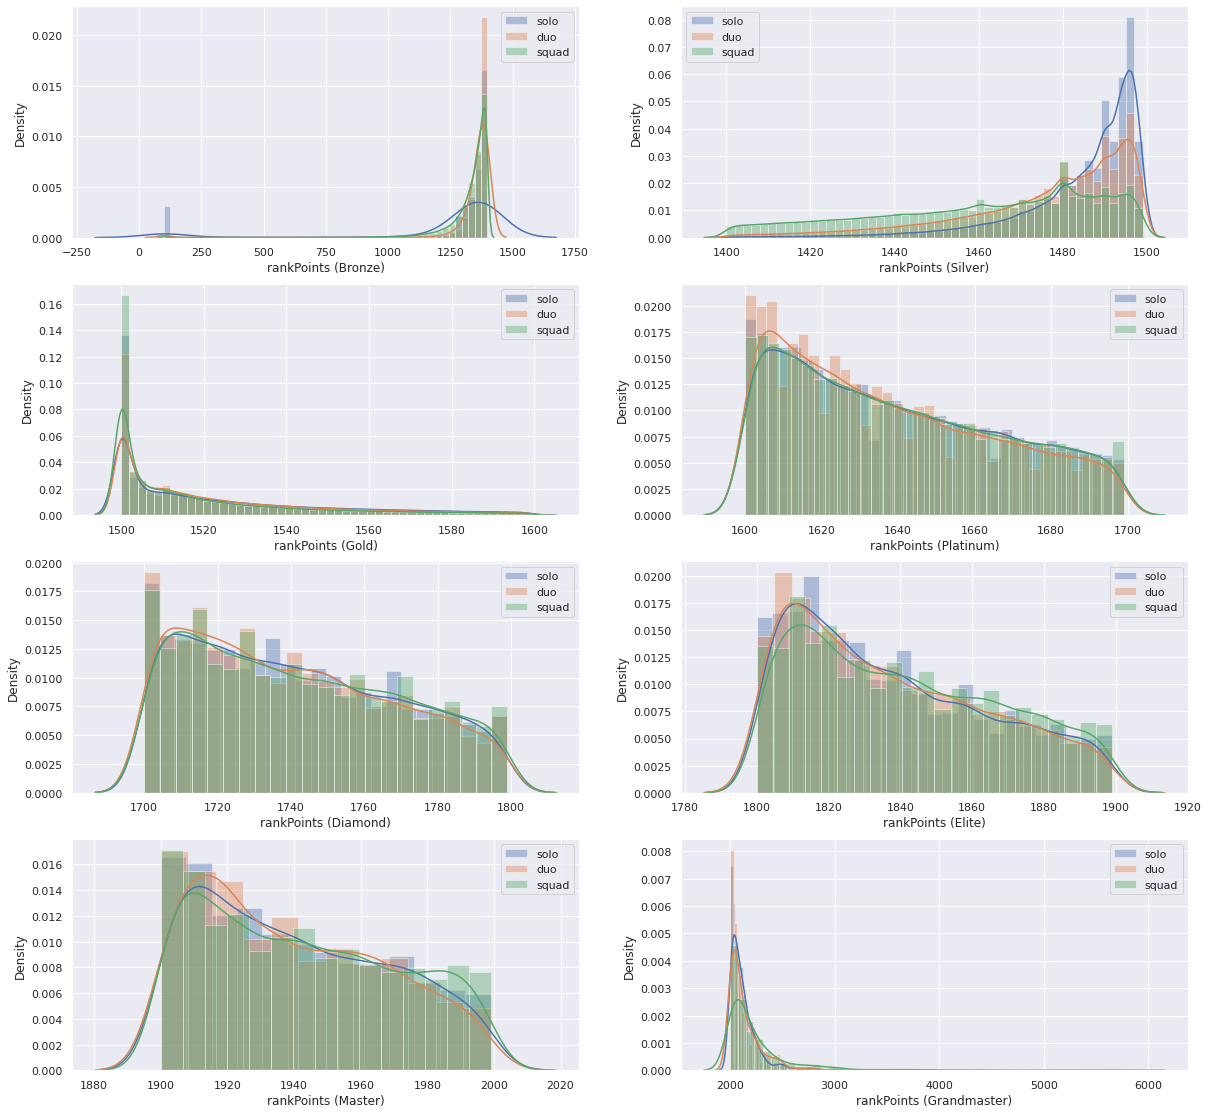

In [ ]:
fig = plt.figure(figsize=(20, 40))

for i, tier in enumerate(tiers):
  graph = fig.add_subplot(8, 2, i + 1)
  for matchType in matchType3:
    sns.distplot(t.loc[((t['tier'] == tier) & (t['matchType3'] == matchType)), 'rankPoints'], label=matchType, ax=graph)
  graph.set_xlabel(f'rankPoints ({tier})')
  graph.legend()

plt.show()

#### 실상은...?

지금까지 랭크전만 살펴보았는데  
대체로 높은 킬 스코어, 티어일 수록 높은 확률로 우승에 가까워 지는 모습이었다.

실제 매칭 시스템의 메커니즘을 알 수는 없지만  
matchId 별로 살펴본 결과 아래처럼 여러 티어들이 한 매치로 만날 경우에는 위 경향이 더욱 뚜렷하게 나타날 것이다.

In [ ]:
matches = t['matchId'].unique()[:20]

for match in matches:
  print(sorted(t.loc[(t['matchId'] == match), 'tier'].unique()))

['Bronze', 'Gold', 'Silver']
['Gold', 'Platinum', 'Silver']
['Bronze', 'Elite', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Elite', 'Gold', 'Grandmaster', 'Master', 'Platinum', 'Silver']
['Bronze', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Platinum', 'Silver']
['Diamond', 'Elite', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Elite', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Silver']
['Diamond', 'Elite', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Elite', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Gold', 'Silver']
['Bronze', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Diamond', 'Gold', 'Platinum', 'Silver']
['Bronze', 'Gold', 'Platinum', 'Silver']
['Gold', 'Platinum', 'Silver']


그러나 이들의 rankPoints 들을 매치별 순위를 매겨 살펴보면 의외의 결과가 나타났다.

In [ ]:
match = t[t['matchId'] == 'aeb375fc57110c'].copy() # 브실골이 존재하는 스쿼드 랭크 매치
match['rankPointPerc'] = match['rankPoints'].rank(pct=True) # rankPoints 를 해당 매치 내에서의 순위를 매김
match[['rankPoints', 'tier', 'rankPointPerc', 'winPlacePerc']].sort_values(by='rankPoints', ascending=False)

rankPoints    tier  rankPointPerc  winPlacePerc
4372821        1549    Gold          1.000         0.120
2666694        1542    Gold          0.989         0.120
1356377        1539    Gold          0.973         1.000
458217         1539    Gold          0.973         0.360
4149389        1537    Gold          0.956         1.000
...             ...     ...            ...           ...
289173         1359  Bronze          0.055         0.760
98093          1349  Bronze          0.044         0.080
2991800        1345  Bronze          0.033         0.000
4045431        1294  Bronze          0.022         0.080
321224         1265  Bronze          0.011         0.760

[91 rows x 4 columns]

대체로 우승은 높은 티어가 차지하기는 했지만 전반적으로는 비례되는 모습이 아니었다.

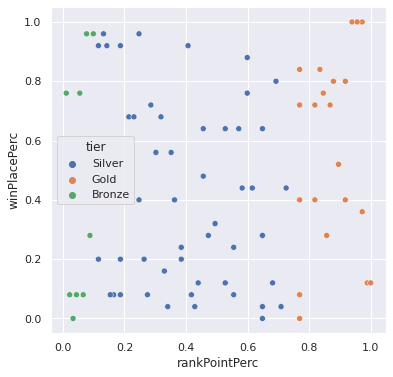

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=match, x='rankPointPerc', y='winPlacePerc', hue='tier')
plt.show()

브론즈 부터 그랜드마스터까지 분포하는 매치에서도 마찬가지였다.

그 와중에 골드가 2등까지 올라간 모습이 보인다.  
(골드 최강설)

In [ ]:
t['rankPointPerc'] = t.groupby('matchId')['rankPoints'].rank(pct=True)

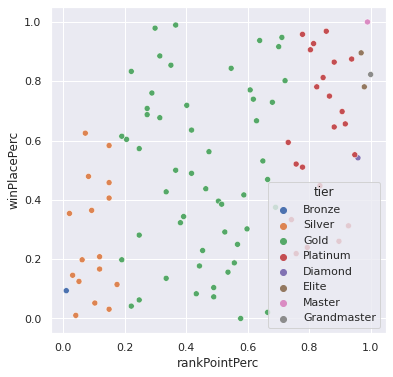

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=t[t['matchId'] == '6dc8ff871e21e6'], x='rankPointPerc', y='winPlacePerc', hue='tier', hue_order=tiers)
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


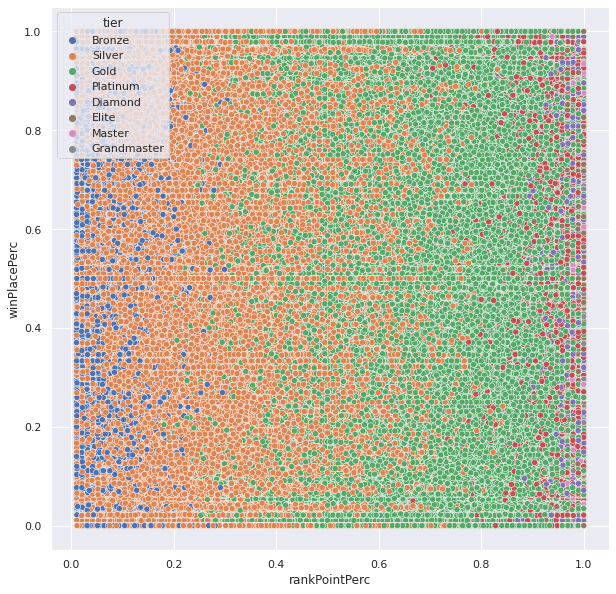

In [ ]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=t, x='rankPointPerc', y='winPlacePerc', hue='tier', hue_order=tiers)
plt.show()

#### 결론

서로 다른 두 데이터간의 실력을 rankPoints 로 비교한다고 가정한다.

그렇다면 이 한가지만으로는 참고가 될까?  
**답은 전혀 아니었다.**

solo, duo, squad 즉, matchType 별로 rankPoints 의 분포가 다른 모습이었기에  
이들을 분류해서 처리할 필요가 있어 보였는데 그럴 필요가 전혀 없었다.

가장 중요한건 **matchId** 와 **groupId** 다.  
최종적으로 구하고자 하는 등수 예측은 전체 데이터를 기준으로 보는것이 아니라 그 데이터가 속한 매치내에서의 결과이기 때문이다.

어떤 매치는 초보자들이 모였을 수도 있고 어떤 매치는 고수들만 모였을 수도 있다.  
이런 경우에 초보자와 고수의 데이터를 비교하는것이 아니라 초보자들끼리 또는 고수들끼리(각각의 매치별끼리) 비교를 해야한다는 것이다.

또한 matchId 별로 나눠지면 matchType 또한 같으므로 이들을 나눠 처리할 필요가 없다.

그리고 groupId 는 duo, squad 인 경우 해당 플레이어가 속한 그룹을 의미하는데  
한명은 아무것도 하고 다른 한명이 팀을 1등으로 만드는 상황이라면 아무것도 안하는 한명에 대해서도 동일한 등수가 부여되어야 한다는 사실을 알고 있어야 한다.

3줄 요약
- matchType 을 신경쓰지 않아도 된다. (하지만 레이트 지표의 경우 3가지가 동시에 존재하는 경우가 없으므로 어느정도 필요해 보인다)
- 최종적으로 구하고자 하는 등수 예측은 전체 데이터가 아닌 그 데이터가 속한 매치 내에서의 등수 결과이다.
- 그러므로 matchId 및 groupId 별로 그룹을 나눠 상대적인 비교가 가능한 지표가 가장 중요하다.

### 추가 분석

위에서 제외되었던 대상들을 기준으로 추가 분석을 진행했다.
- 랭크전 (rankPoints 가 -1 또는 0 인 경우)
- 일반전
- 이벤트전

In [ ]:
t = train.copy()
t = preprocess_matchType(t)

In [ ]:
rank = t[(t['matchType2'] == 'rank') & (t['rankPoints'] <= 0)]
normal = t[t['matchType2'] == 'normal']
event = t[t['matchType2'] == 'event']

#### 랭크전 (rankPoints 가 -1 또는 0 인 경우)

이 경우에는 rankPoints 지표를 참고할 수 없는 대신 killPoints 및 winPoints 값이 존재하므로 이를 대체할 수 있어보인다.  
(사실 이 경우뿐만 아니라 전체 데이터상에서도 두 컬럼(rankPoints 와 나머지)간의 데이터가 동시에 존재하는 경우가 없다)

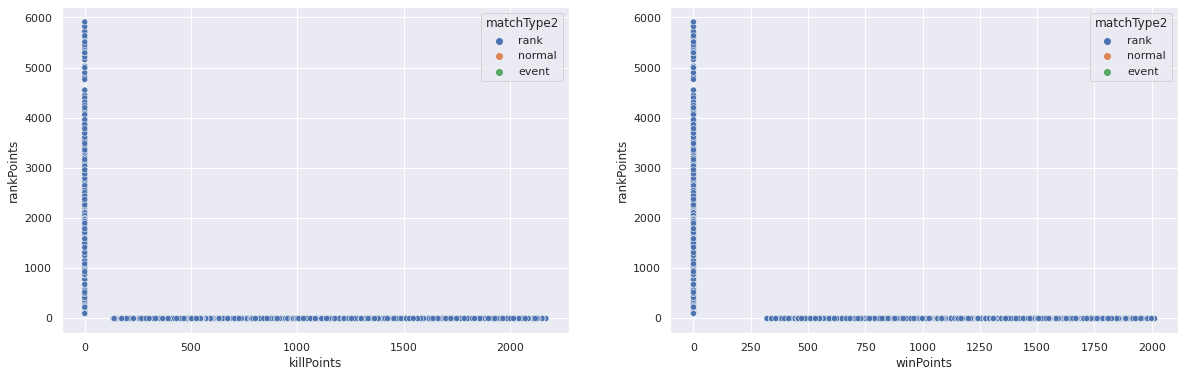

In [ ]:
fig = plt.figure(figsize=(20, 6))
graph1 = fig.add_subplot(1, 2, 1)
graph2 = fig.add_subplot(1, 2, 2)

sns.scatterplot(data=t, x='killPoints', y='rankPoints', hue='matchType2', ax=graph1)
sns.scatterplot(data=t, x='winPoints', y='rankPoints', hue='matchType2', ax=graph2)
plt.show()

In [ ]:
rank[['killPoints', 'winPoints']].head()

killPoints  winPoints
0         1241       1466
6         1262       1497
7         1000       1500
13         986       1462
14        1411       1531

In [ ]:
print(len(rank[rank['killPoints'] <= 0]))
print(len(rank[rank['winPoints'] <= 0]))

0
0


In [ ]:
rank.corr()['winPlacePerc'].sort_values()

killPlace         -0.721
teamKills         -0.008
matchDuration     -0.003
rankPoints        -0.001
roadKills          0.029
maxPlace           0.037
numGroups          0.039
vehicleDestroys    0.065
killPoints         0.115
swimDistance       0.151
winPoints          0.228
revives            0.243
headshotKills      0.279
DBNOs              0.284
assists            0.305
rideDistance       0.325
killStreaks        0.373
longestKill        0.408
kills              0.428
heals              0.430
damageDealt        0.451
weaponsAcquired    0.618
boosts             0.634
walkDistance       0.819
winPlacePerc       1.000
Name: winPlacePerc, dtype: float64

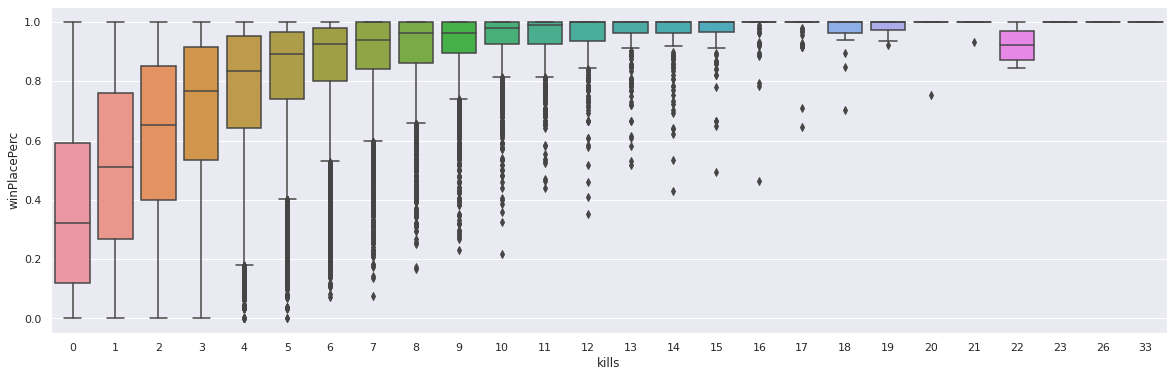

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=rank, x='kills', y='winPlacePerc')
plt.show()

팀 유무별

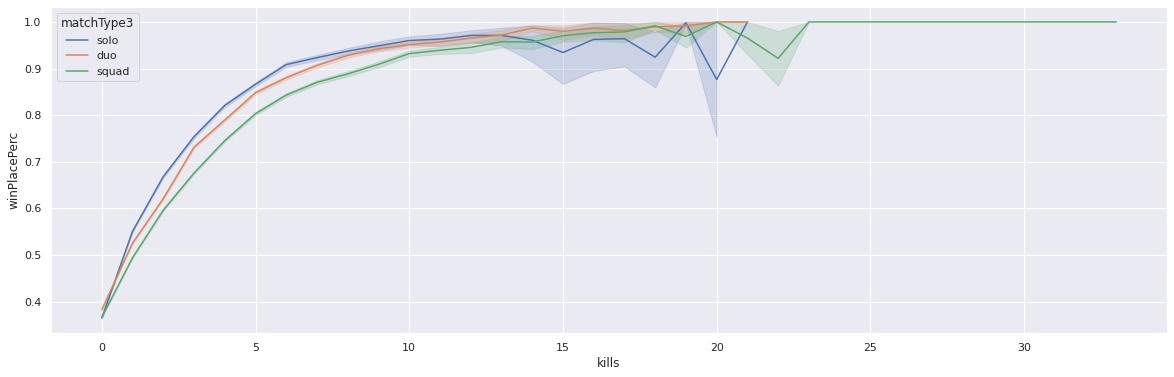

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=rank, x='kills', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

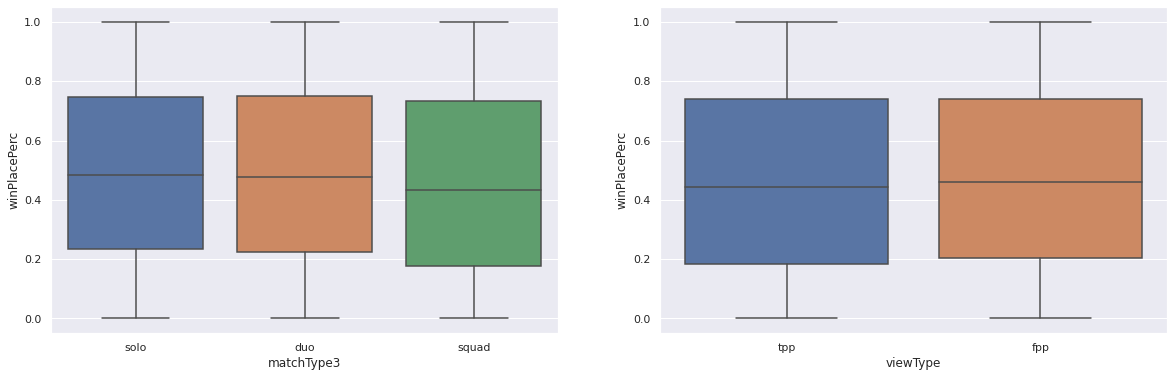

In [ ]:
fig = plt.figure(figsize=(20, 6))
graph1 = fig.add_subplot(1, 2, 1)
graph2 = fig.add_subplot(1, 2, 2)

sns.boxplot(data=rank, x='matchType3', y='winPlacePerc', order=matchType3, ax=graph1)
sns.boxplot(data=rank, x='viewType', y='winPlacePerc', order=viewType, ax=graph2)
plt.show()

이들 사이에서도 실력의 편차가 존재하기 때문에 위 결과만으로 봐서는 이들의 관계를 알 수 없으므로  
rankPoints 때 처럼 실력 별로 세분화하여 볼 필요가 있어 보인다.

참고해볼 지표는 killPoints 와 winPoints 가 있다.  
먼저 상관계수부터 살펴보면 rankPoints 와 비슷하게 나오는 모습이다.

In [ ]:
rank.corr().loc[['killPoints', 'winPoints'], 'winPlacePerc']

killPoints   0.115
winPoints    0.228
Name: winPlacePerc, dtype: float64

분포는 다음과 같다.

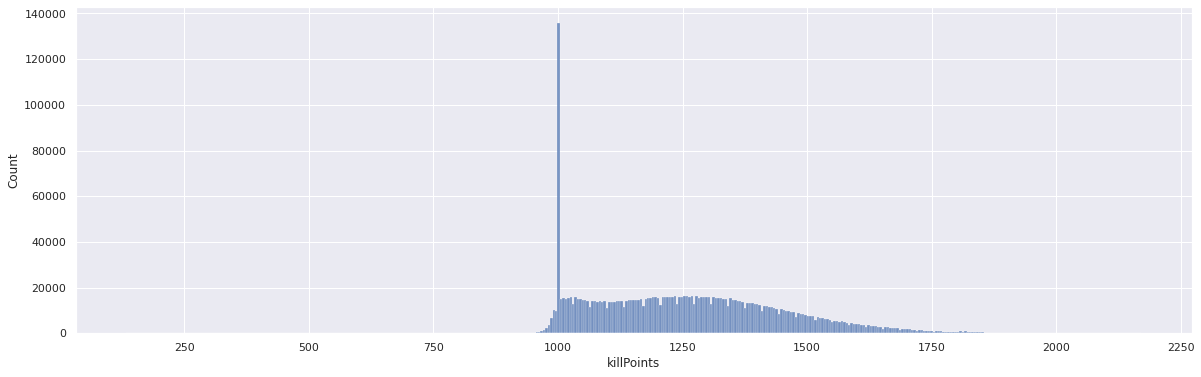

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=rank, x='killPoints')
plt.show()

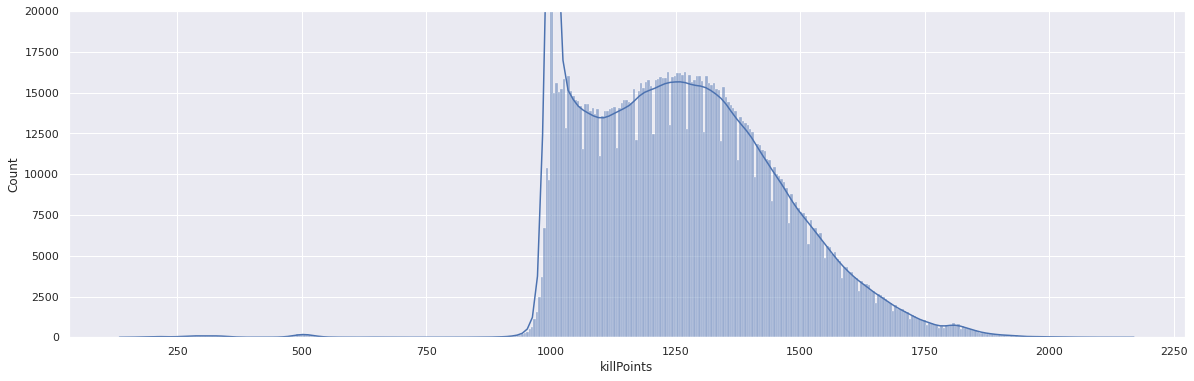

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=rank, x='killPoints', kde=True)
plt.ylim(0, 20000)
plt.show()

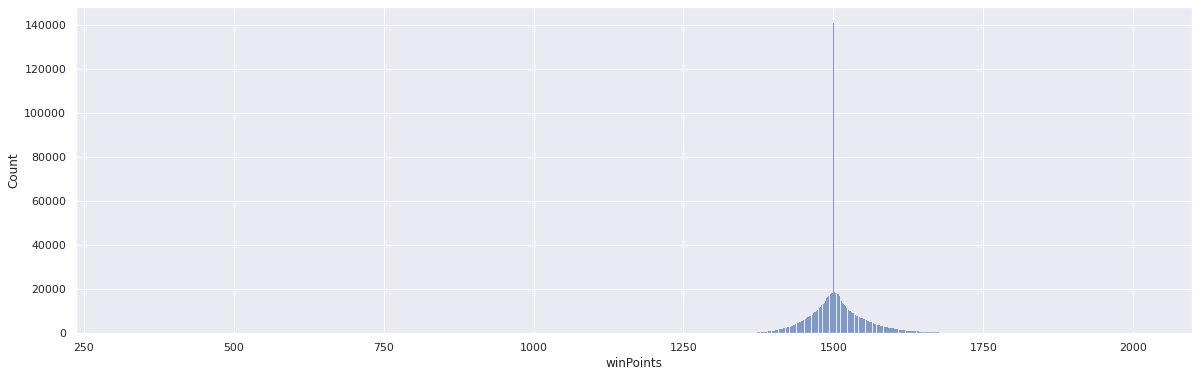

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=rank, x='winPoints')
plt.show()

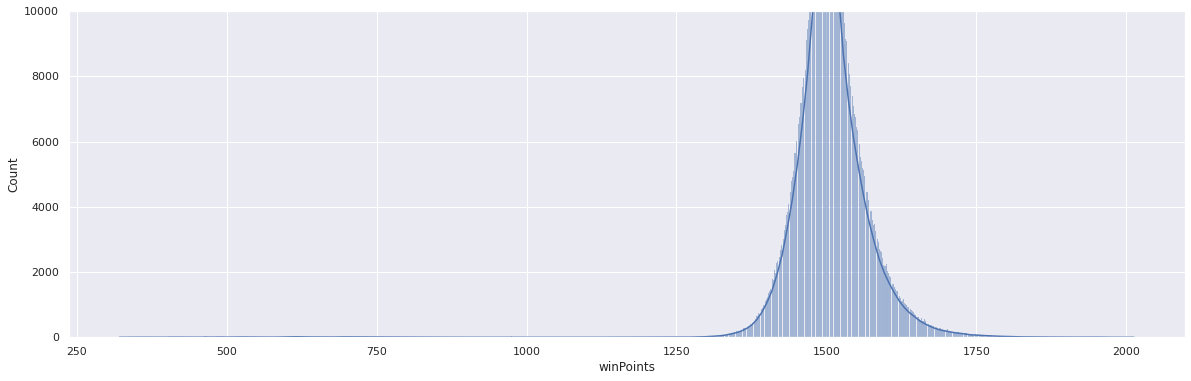

In [ ]:
plt.figure(figsize=(20, 6))
sns.histplot(data=rank, x='winPoints', kde=True)
plt.ylim(0, 10000)
plt.show()

rankPoints 때 처럼 특정 구간의 분포가 눈에 띈다.  
이 값들 역시 Unranked 상태 또는 초기값으로 판단된다.

이들이 처음으로 게임을 플레이 한 것인지 아니면 부계정인지는 알 수 없으므로 대상에서 함부로 제외하기는 힘들어 보인다.

In [ ]:
rank['killPoints'].mode()

0    1000
dtype: int16

In [ ]:
rank['winPoints'].mode()

0    1500
dtype: int16

다시 한번 매치 타입별로 살펴보면 rankPoints 와 동일하게 이들간의 분포 차이가 확인된다.

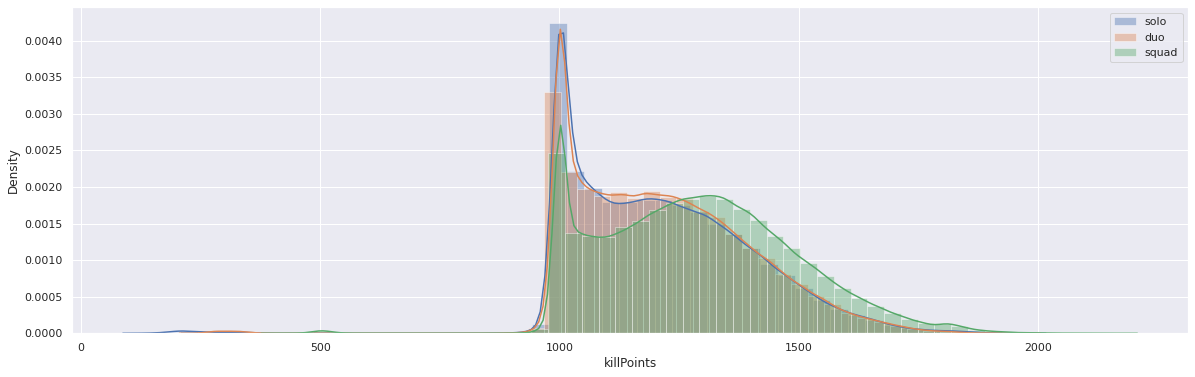

In [ ]:
plt.figure(figsize=(20, 6))
for matchType in matchType3:
  sns.distplot(rank.loc[(rank['matchType3'] == matchType), 'killPoints'], label=matchType)
plt.legend()
plt.show()

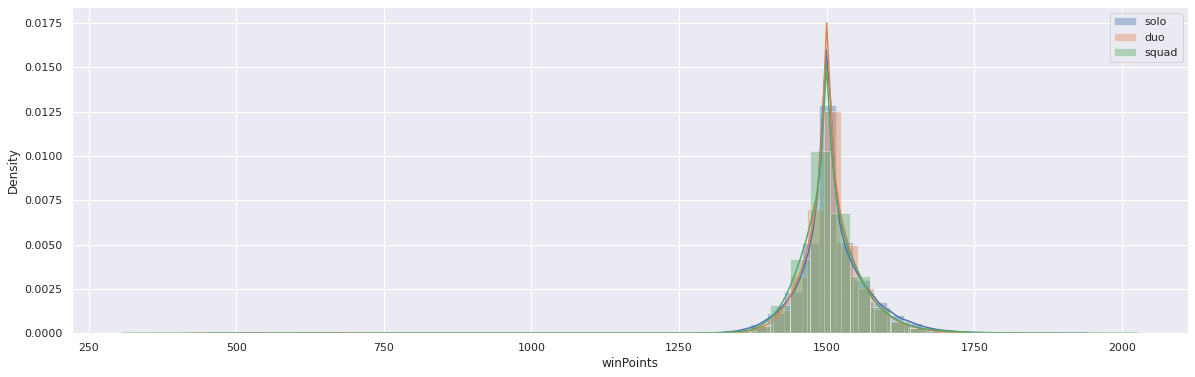

In [ ]:
plt.figure(figsize=(20, 6))
for matchType in matchType3:
  sns.distplot(rank.loc[(rank['matchType3'] == matchType), 'winPoints'], label=matchType)
plt.legend()
plt.show()

또한 X 축이 낮은 부분을 살펴보면 매치 타입별로 일부 군집이 형성된 모습이 나타난다.

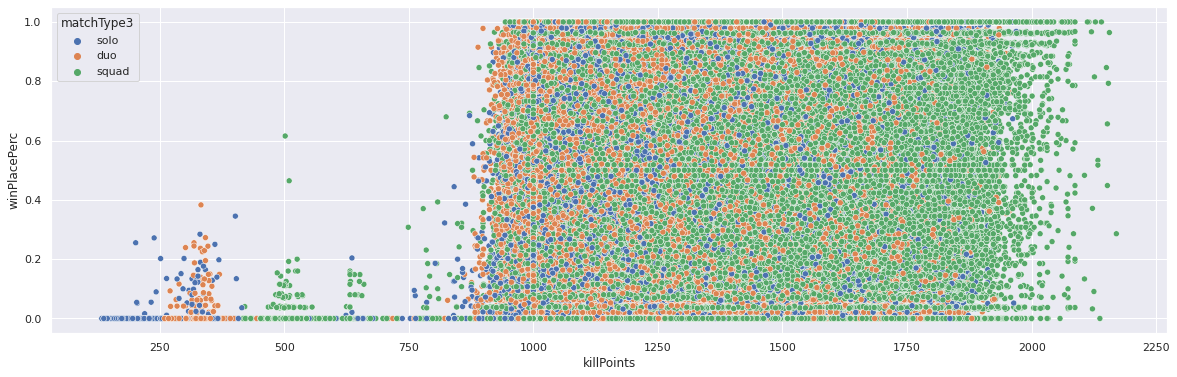

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=rank, x='killPoints', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

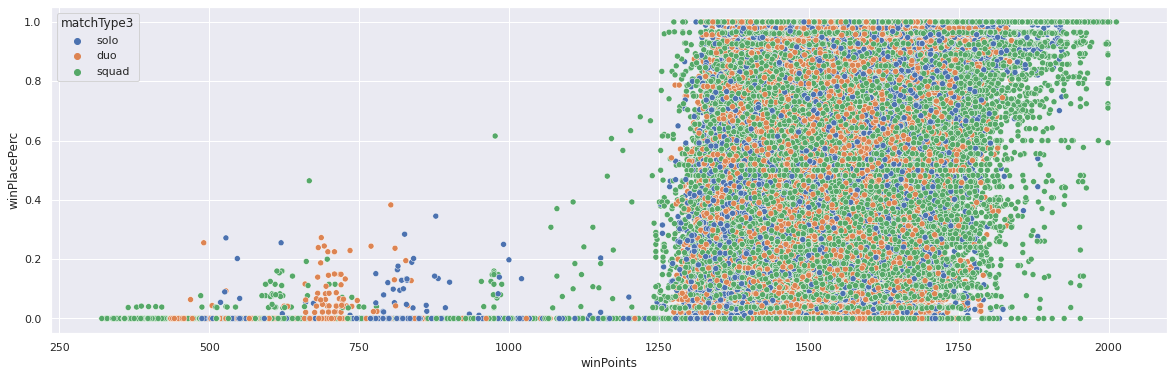

In [ ]:
plt.figure(figsize=(20, 6))
sns.scatterplot(data=rank, x='winPoints', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

In [ ]:
totalRank = t[t['matchType2'] == 'rank']

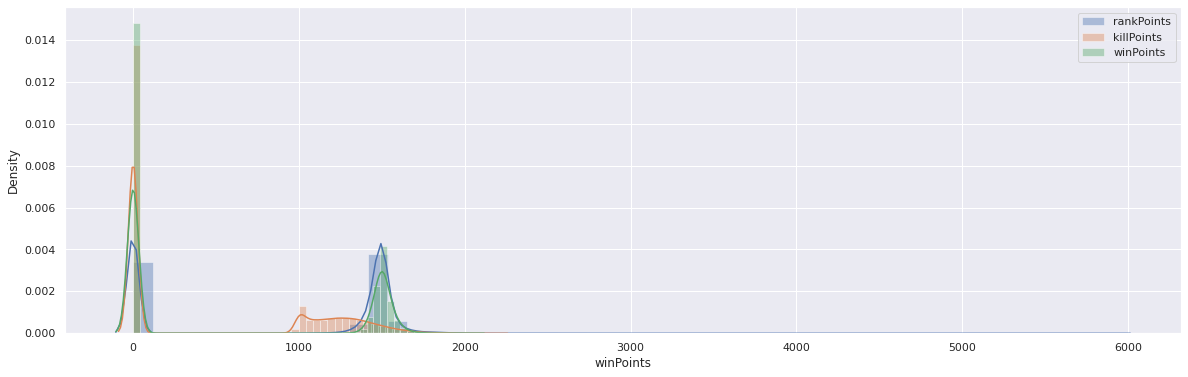

In [ ]:
plt.figure(figsize=(20, 6))
sns.distplot(totalRank['rankPoints'], label='rankPoints')
sns.distplot(totalRank['killPoints'], label='killPoints')
sns.distplot(totalRank['winPoints'], label='winPoints')
plt.legend()
plt.show()

#### 일반전

In [ ]:
normal.corr()['winPlacePerc'].sort_values()

killPlace         -0.525
matchDuration     -0.059
teamKills         -0.032
numGroups         -0.010
killPoints        -0.005
winPoints         -0.005
maxPlace          -0.000
rankPoints         0.005
roadKills          0.024
swimDistance       0.028
vehicleDestroys    0.081
rideDistance       0.092
weaponsAcquired    0.096
revives            0.140
DBNOs              0.156
heals              0.207
assists            0.219
headshotKills      0.223
walkDistance       0.273
longestKill        0.275
kills              0.288
damageDealt        0.303
boosts             0.315
killStreaks        0.340
winPlacePerc       1.000
Name: winPlacePerc, dtype: float64

일반전의 경우 아래 3가지의 레이트 지표값을 모두 알 수 없는 상태다.

In [ ]:
normal['rankPoints'].unique()

array([1500,   -1,    0], dtype=int16)

In [ ]:
normal['killPoints'].unique()

array([   0, 1000], dtype=int16)

In [ ]:
normal['winPoints'].unique()

array([   0, 1500], dtype=int16)

또한 랭크전과 다소 분포가 다른 모양으로 나타난다.

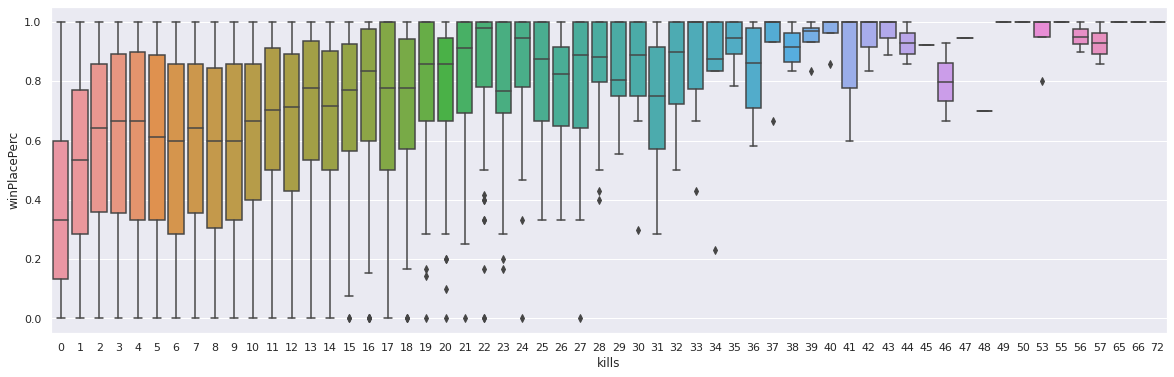

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=normal, x='kills', y='winPlacePerc')
plt.show()

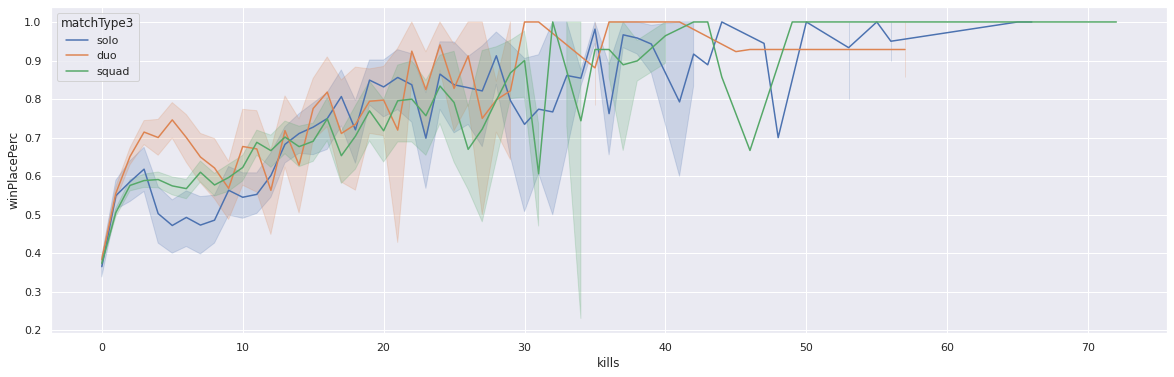

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=normal, x='kills', y='winPlacePerc', hue='matchType3', hue_order=matchType3)
plt.show()

#### 이벤트전

In [ ]:
event.corr()['winPlacePerc'].sort_values()

killPlace         -0.723
matchDuration     -0.055
winPoints         -0.016
killPoints        -0.016
teamKills          0.015
rankPoints         0.016
maxPlace           0.048
numGroups          0.050
swimDistance       0.068
headshotKills      0.135
revives            0.169
vehicleDestroys    0.210
longestKill        0.261
DBNOs              0.280
assists            0.303
roadKills          0.314
weaponsAcquired    0.331
damageDealt        0.380
killStreaks        0.395
heals              0.402
kills              0.421
walkDistance       0.481
boosts             0.579
rideDistance       0.637
winPlacePerc       1.000
Name: winPlacePerc, dtype: float64

일반전과 마찬가지로 이벤트전도 동일하다.

In [ ]:
event['rankPoints'].unique()

array([1500,   -1], dtype=int16)

In [ ]:
event['killPoints'].unique()

array([   0, 1000], dtype=int16)

In [ ]:
event['winPoints'].unique()

array([   0, 1500], dtype=int16)

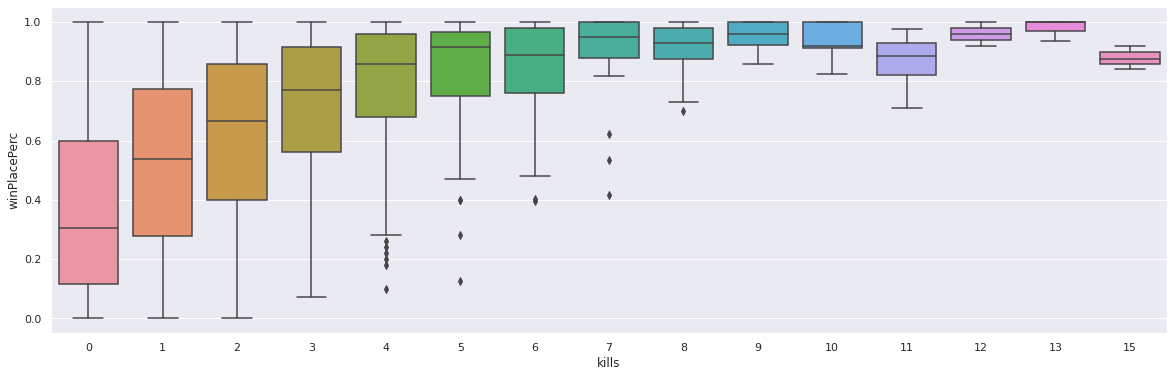

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(data=event, x='kills', y='winPlacePerc')
plt.show()

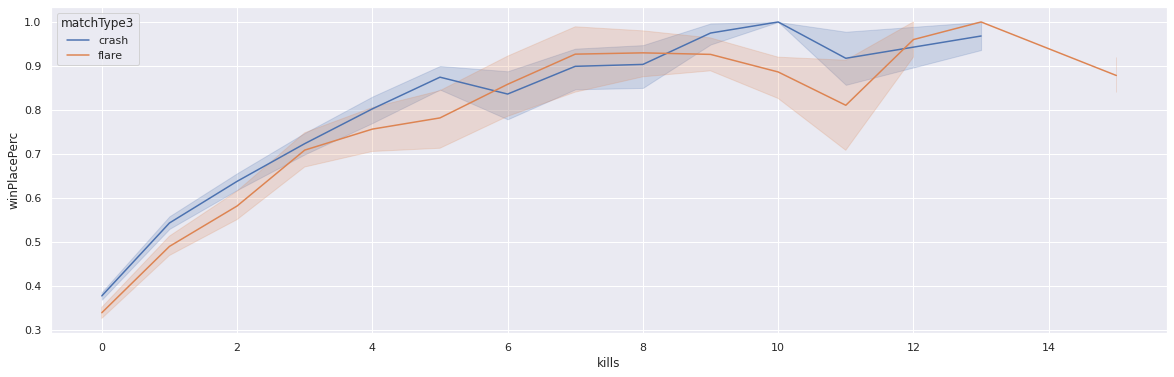

In [ ]:
plt.figure(figsize=(20, 6))
sns.lineplot(data=event, x='kills', y='winPlacePerc', hue='matchType3', hue_order=['crash', 'flare'])
plt.show()

#### 가설에 대한 모델링 아이디어 (폐기됨)

- matchType 을 기준으로 랭크전, 일반전, 이벤트전으로 분류한다.
- 랭크전의 경우 rankPoints 가 0 또는 -1 인 경우와 정상적인 경우로 분류한다.
  - rankPoints 가 0 또는 -1 인 경우는 killPoints, winPoints 에 의존한다.
  - rankPoints 가 정상적인 경우는 위 두값을 알 수 없으므로 rankPoints 에 의존한다.
- 일반전 및 이벤트전의 경우 레이트 지표를 제외한 나머지 컬럼에 의존한다.
- 세부적으로 solo, duo, squad 로 나눠지는 경우는 이들 모두 레이트 분포가 다르거나 경기 난이도가 달라지므로 서로 다른 모델을 적용해보거나 카테고리 피처로 추가한다.
  - 특히 duo, squad 의 경우 팀워크 지표를 추가로 참고해본다.
- 시점(tpp, fpp)별로 카테고리 피처를 추가한다.

## 데이터 전처리 (Feature Engineering)

### 컬럼 추가

#### matchId 별 개인(플레이어)

In [ ]:
# 레이트 지표
def preprocess_point(df):
  # 방법 1

  # # 랭크전이 아닌 경우 레이트 지표는 모두 -1
  # df.loc[df['matchType2'] != 'rank', 'rankPoints'] = -1
  # df.loc[df['matchType2'] != 'rank', 'killPoints'] = -1
  # df.loc[df['matchType2'] != 'rank', 'winPoints'] = -1

  # # 랭크전 중에서 rankPoints 가 정상적인 경우는 나머지 레이트 지표를 모두 -1 로 병합
  # df.loc[(df['matchType2'] == 'rank') & (df['rankPoints'] > 0), 'killPoints'] = -1
  # df.loc[(df['matchType2'] == 'rank') & (df['rankPoints'] > 0), 'winPoints'] = -1

  # # 랭크전 중에서 레이트 지표가 0 인 경우는 -1 로 병합
  # df.loc[(df['matchType2'] == 'rank') & (df['rankPoints'] == 0), 'rankPoints'] = -1
  # df.loc[(df['matchType2'] == 'rank') & (df['killPoints'] == 0), 'killPoints'] = -1
  # df.loc[(df['matchType2'] == 'rank') & (df['winPoints'] == 0), 'winPoints'] = -1


  # 방법 2

  df.loc[(df['rankPoints'] < 0), 'rankPoints'] = 0
  df.loc[(df['killPoints'] < 0), 'killPoints'] = 0 # killPoints 또는 winPoints 둘 중 하나

  df['points'] = df['rankPoints'] + df['killPoints']

  df['pointsPerc'] = df.groupby('matchId')['points'].rank(pct=True)

  return df


# 팀플레이 지표
def preprocess_teamplay(df):
  # # solo 인 경우 팀플레이 관련 지표는 -1 로 병합
  # df.loc[df['matchType3'] == 'solo', 'assists'] = -1
  # df.loc[df['matchType3'] == 'solo', 'DBNOs'] = -1
  # df.loc[df['matchType3'] == 'solo', 'revives'] = -1
  # df.loc[df['matchType3'] == 'solo', 'teamKills'] = -1

  df['DBNOsPerc'] = df.groupby('matchId')['DBNOs'].rank(pct=True) # 가장 importance 한 팀 지표

  return df


# 킬 지표
def preprocess_kill(df):
  df['killsPerc'] = df.groupby('matchId')['kills'].rank(pct=True)
  df['longestKillPerc'] = df.groupby('matchId')['longestKill'].rank(pct=True)
  df['killPlacePerc'] = df.groupby('matchId')['killPlace'].rank(pct=True) # to Percentage

  df['killStreaksPerKill'] = df['killStreaks'] / df['kills']
  df['headShotPerKill'] = df['headshotKills'] / df['kills'] # 영향 없음
  df['damageDealtPerKill'] = df['damageDealt'] / df['kills']
  df['matchDurationPerKill'] = df['matchDuration'] / df['kills']

  df['killPlace_maxPlace_Ratio'] = df['killPlace'] / df['maxPlace']
  
  return df


# 이동 지표
def preprocess_distance(df):
  df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']

  df['walkDistancePerc'] = df.groupby('matchId')['walkDistance'].rank(pct=True)
  df['totalDistancePerc'] = df.groupby('matchId')['totalDistance'].rank(pct=True)

  df['totalDistancePerDuration'] = df['totalDistance'] / df['matchDuration']
  df['walkDistancePerDuration'] = df['walkDistance'] / df['matchDuration']
  df['walkDistancePerKill'] = df['walkDistance'] / df['kills']
  df['totalDistancePerKill'] = df['totalDistance'] / df['kills']
  df['totalDistancePerHeal'] = df['totalDistance'] / df['heals'] # 영향 없음

  # 아래와 같이 의미적으로 해석하기 힘든 컬럼은 단순히 importance 한 컬럼들의 관계를 나타내는 용도다.
  df['killsPerc_walkDistancePerc_Ratio'] = df['killsPerc'] / df['walkDistancePerc']
  df['killsPerc_totalDistancePerc_Ratio'] = df['killsPerc'] / df['totalDistancePerc']
  df['killPlacePerc_walkDistancePerc_Ratio'] = df['killPlacePerc'] / df['walkDistancePerc']
  df['killPlacePerc_totalDistancePerc_Ratio'] = df['killPlacePerc'] / df['totalDistancePerc']

  return df


# 아이템 지표
def preprocess_item(df):
  df['items'] = df['boosts'] + df['heals']

  df['itemsPerc'] = df.groupby('matchId')['items'].rank(pct=True)
  df['weaponsAcquiredPerc'] = df.groupby('matchId')['weaponsAcquired'].rank(pct=True)

  df['totalDistancePerItem'] = df['totalDistance'] / df['items'] # 영향 없음
  df['totalDistancePerWeapon'] = df['totalDistance'] / df['weaponsAcquired']

  return df


# 0으로 나눠버린 경우들은 0으로 처리
def preprocess_inf(df):
  df[df == np.Inf] = np.NaN
  df[df == np.NINF] = np.NaN
  df.fillna(0, inplace=True)

  return df

In [ ]:
# train = preprocess_matchType(train)
train = preprocess_point(train)
train = preprocess_teamplay(train)
train = preprocess_kill(train)
train = preprocess_distance(train)
train = preprocess_item(train)

train = preprocess_inf(train)
train = reduce_mem_usage(train)

Memory usage of dataframe is 1115.37 MB --> 826.99 MB (Decreased by 25.9%)


#### matchId 별 그룹(파티)

In [ ]:
groupby = ['matchId', 'groupId']

features = [
  'kills', 'killsPerc',
  'killPlace', 'killPlacePerc', 
  'walkDistance', 'walkDistancePerc',
  # 'totalDistance', 'totalDistancePerc',
  'killPlace_maxPlace_Ratio', 
  'killsPerc_walkDistancePerc_Ratio',
  'killPlacePerc_walkDistancePerc_Ratio',
]

def preprocess_groupby_groupId(df, fn):
  df_group = df.groupby(groupby)[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_group_{fn}'], how='left', on=groupby)

  df_group_rank = df_group.groupby('matchId')[features].rank(pct=True)
  df = pd.merge(df, df_group_rank, suffixes=['', f'_group_{fn}_rank'], how='left', on=groupby)

  del df_group
  del df_group_rank
  gc.collect()

  return df


def preprocess_group_size(df):
  df_group = df.groupby(groupby).size().reset_index(name='groupSize')
  df = pd.merge(df, df_group, how='left', on=groupby)

  del df_group
  gc.collect()

  return df

In [ ]:
train = preprocess_groupby_groupId(train, 'mean')
train = preprocess_groupby_groupId(train, 'min')
train = preprocess_groupby_groupId(train, 'max')
# train = preprocess_groupby_groupId(train, 'std')
train = preprocess_group_size(train)

train = reduce_mem_usage(train)

Memory usage of dataframe is 2218.02 MB --> 1696.38 MB (Decreased by 23.5%)


#### matchId 별 난이도(매칭)

In [ ]:
groupby = ['matchId']

def preprocess_groupby_matchId(df, fn):
  df_group = df.groupby(groupby)[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_match_{fn}'], how='left', on=groupby)

  del df_group
  gc.collect()

  return df


def preprocess_match_size(df):
  df_group = df.groupby(groupby).size().reset_index(name='matchSize')
  df = pd.merge(df, df_group, how='left', on=groupby)

  del df_group
  gc.collect()

  return df

In [ ]:
train = preprocess_groupby_matchId(train, 'mean')
train = preprocess_groupby_matchId(train, 'min')
train = preprocess_groupby_matchId(train, 'max')
# train = preprocess_groupby_matchId(train, 'std')
train = preprocess_match_size(train)

train = reduce_mem_usage(train)

Memory usage of dataframe is 2171.37 MB --> 2107.76 MB (Decreased by 2.9%)


In [ ]:
null_count = train.isnull().sum()
null_count[null_count > 0]

Series([], dtype: int64)

In [ ]:
corr = train.corr()

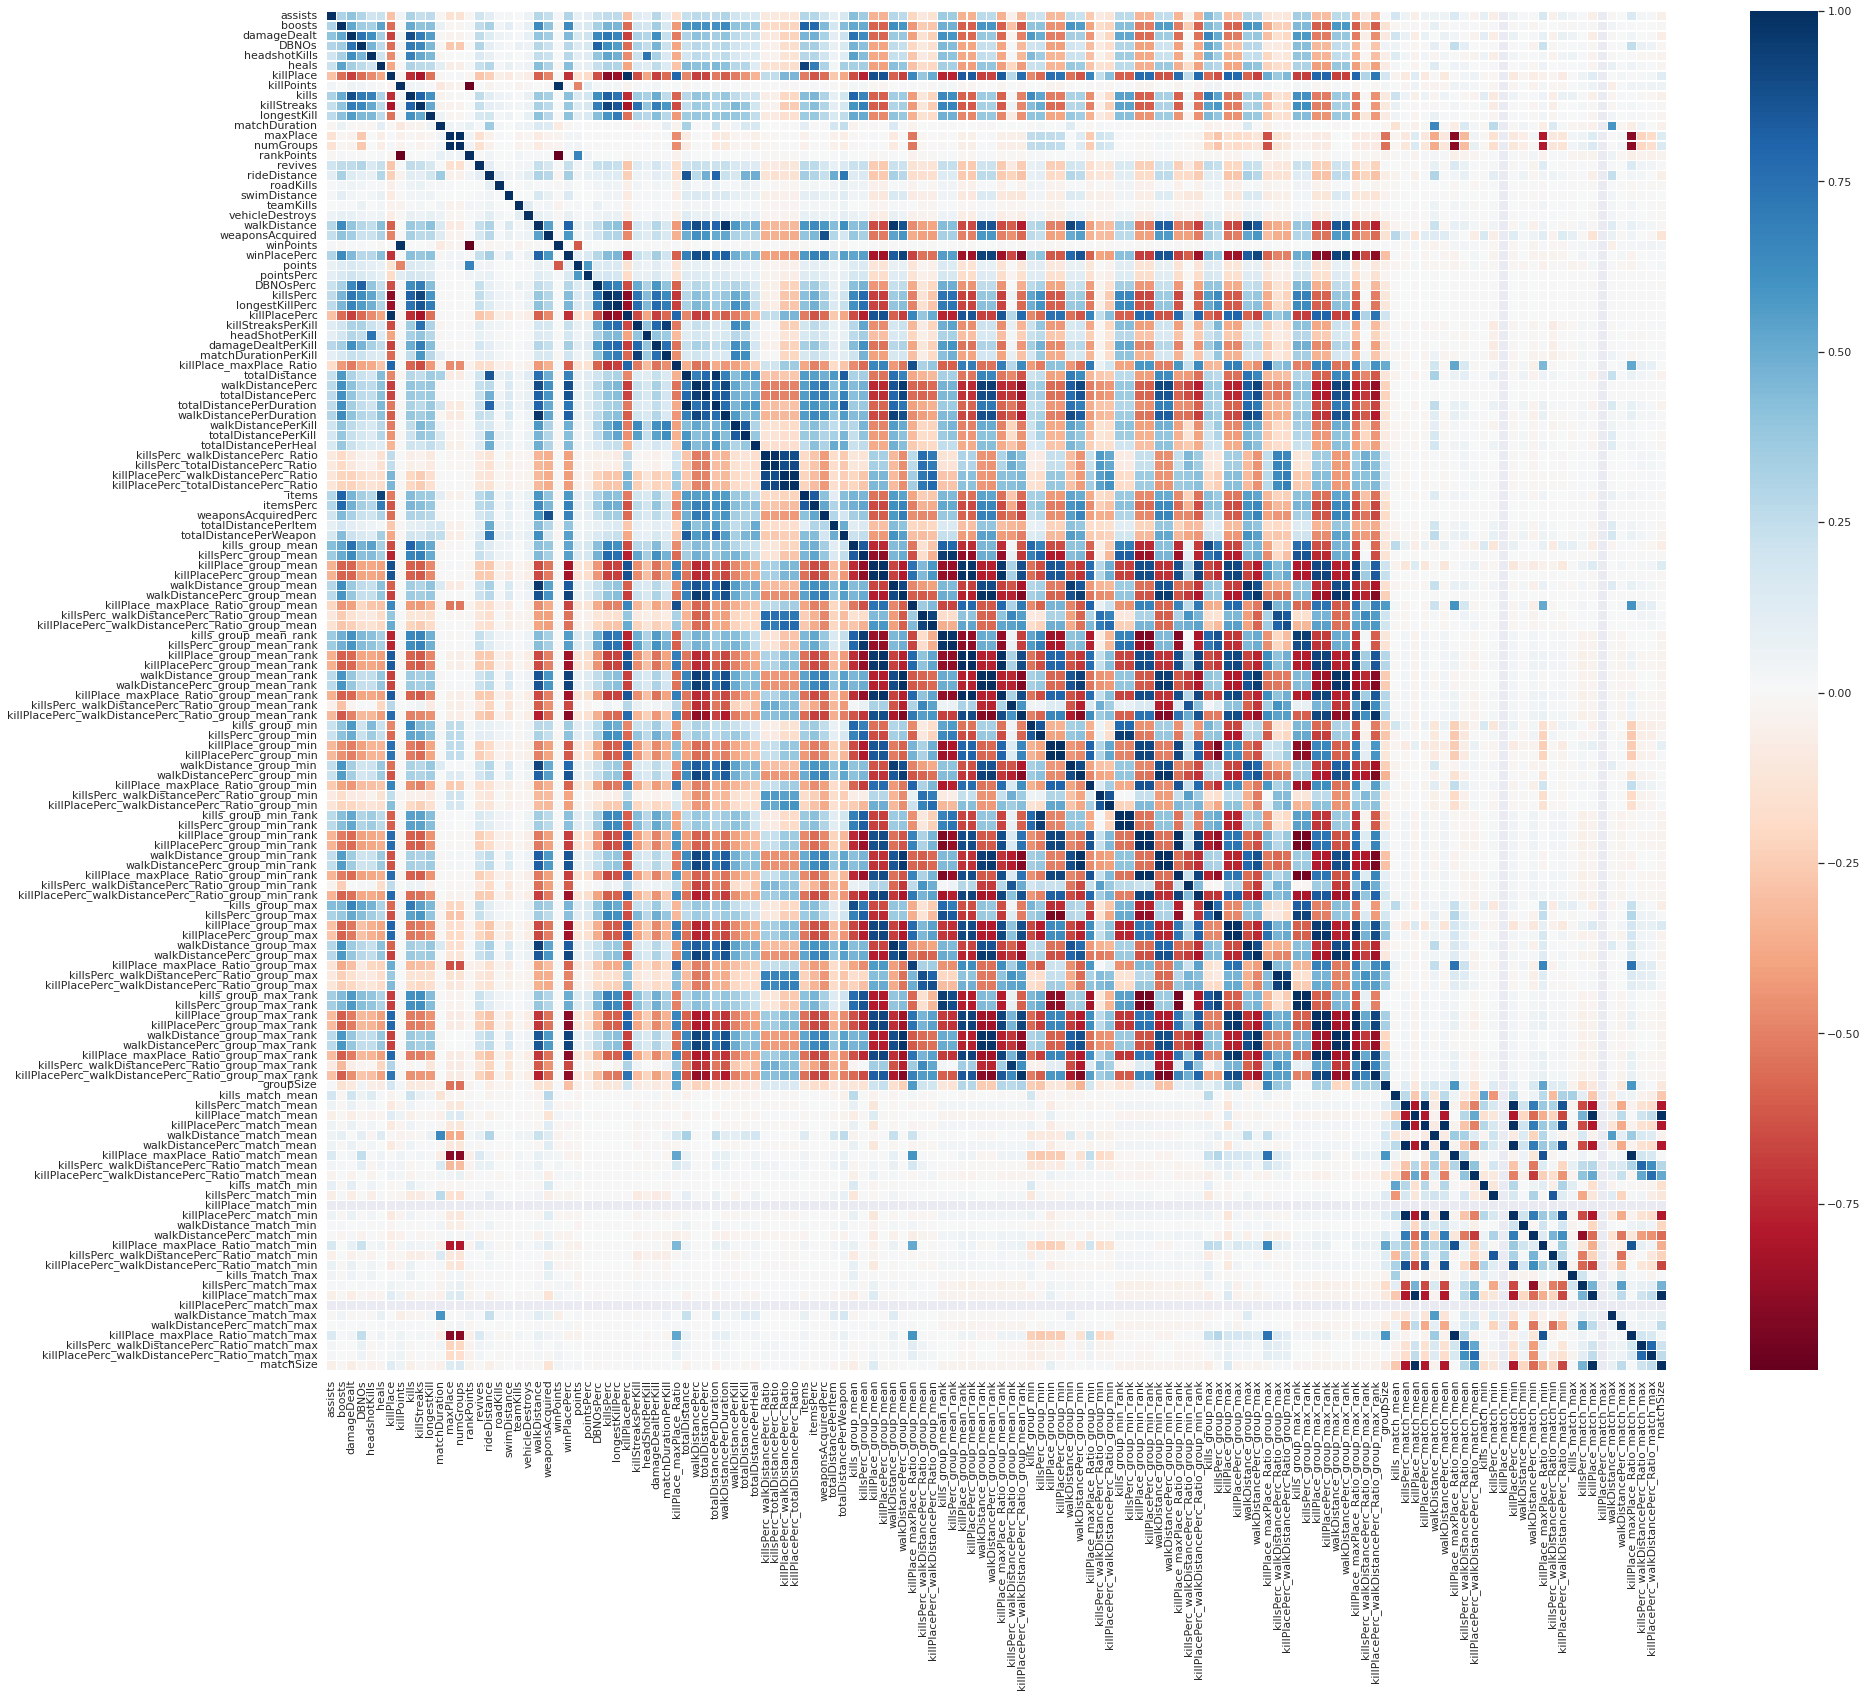

In [ ]:
plt.figure(figsize=(30,25))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='white',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

### 레이블 분리

In [ ]:
X = train.drop('winPlacePerc', axis=1)
y = train['winPlacePerc']

### 컬럼 선정

#### 제외

In [ ]:
except_attribs = [
  'Id', 'groupId', 'matchId', 

  # importance 가 10 미만인 컬럼들
  'assists', 'DBNOs', 'teamKills',
  'rankPoints', 'killPoints', 'points', 'pointsPerc', # 결국 레이트 지표는 참고가 되지 않았다


  # importance 가 0 인 컬럼들

  'killPlacePerc_walkDistancePerc_Ratio', 'cat_5', 'cat_14',
  'cat_13', 'cat_12', 'cat_11', 'cat_10', 'cat_9', 'cat_8', 'cat_7',
  'cat_6', 'cat_4', 'kills_match_max', 'killPlace_match_mean',
  'cat_2', 'cat_1', 'cat_0',
  'killPlace_maxPlace_Ratio_group_min_rank',
  'killPlace_maxPlace_Ratio_group_max_rank',
  'walkDistance_match_max', 'killsPerc_match_max', 'cat_3',


  'cat_11', 'cat_10', 'cat_9', 'cat_2', 'cat_8', 'cat_7', 'cat_6',
  'cat_5', 'cat_4', 'cat_13', 'cat_14',
  'totalDistancePerc_group_max_rank', 'heals', 'cat_1',
  'headshotKills', 'totalDistancePerc_group_min_rank',
  'totalDistancePerc_match_max', 'roadKills', 'vehicleDestroys',
  'totalDistance_match_min', 'headShotPerKill', 'totalDistance',
  'totalDistancePerHeal', 'killPlacePerc_totalDistancePerc_Ratio',
  'totalDistancePerItem', 'cat_15',


  'vehicleDestroys', 'cat_5', 'totalDistancePerHeal',
  'walkDistancePerc_match_max', 'matchSize', 'cat_1', 'cat_2',
  'killsPerc_walkDistancePerc_Ratio', 'cat_4', 'cat_6',
  'killPlace_match_max', 'cat_7', 'cat_8', 'cat_9', 'cat_10',
  'cat_11', 'cat_12', 'cat_13', 'cat_14', 'killPlacePerc_match_max',
  'killsPerc_group_min_rank', 'teamKills', 'walkDistancePerDuration',
  'killsPerc_group_max_rank', 'roadKills',
  'killPlacePerc_group_max_rank', 'walkDistancePerc_group_max_rank',
  'pointsPerc', 'longestKillPerc', 'heals',
  'walkDistancePerc_group_min_rank', 'killPlacePerc_match_mean',
  'headshotKills', 'headShotPerKill', 'kills_match_min',
  'killPlacePerc_group_min_rank', 'killPlace_match_min',
  'killPlacePerc_match_min', 'walkDistance_match_min', 'damageDealt',
  'walkDistancePerc_match_mean',
]

#### 범주형

In [ ]:
ord_attribs = [] # ['matchType3', 'viewType']
cat_attribs = ['matchType']

In [ ]:
cat_size = train['matchType'].nunique()

#### 수치형

In [ ]:
remove_attribs = except_attribs + ord_attribs + cat_attribs
num_attribs = list(X.columns)

for attrib in remove_attribs:
  if attrib in num_attribs:
    num_attribs.remove(attrib)

In [ ]:
columns = num_attribs + ord_attribs + [f'cat_{i}' for i in range(cat_size)]
columns

['boosts',
 'killPlace',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'maxPlace',
 'numGroups',
 'revives',
 'rideDistance',
 'swimDistance',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'DBNOsPerc',
 'killsPerc',
 'killPlacePerc',
 'killStreaksPerKill',
 'damageDealtPerKill',
 'matchDurationPerKill',
 'killPlace_maxPlace_Ratio',
 'walkDistancePerc',
 'totalDistancePerc',
 'totalDistancePerDuration',
 'walkDistancePerKill',
 'totalDistancePerKill',
 'killsPerc_totalDistancePerc_Ratio',
 'items',
 'itemsPerc',
 'weaponsAcquiredPerc',
 'totalDistancePerWeapon',
 'kills_group_mean',
 'killsPerc_group_mean',
 'killPlace_group_mean',
 'killPlacePerc_group_mean',
 'walkDistance_group_mean',
 'walkDistancePerc_group_mean',
 'killPlace_maxPlace_Ratio_group_mean',
 'killsPerc_walkDistancePerc_Ratio_group_mean',
 'killPlacePerc_walkDistancePerc_Ratio_group_mean',
 'kills_group_mean_rank',
 'killsPerc_group_mean_rank',
 'killPlace_group_mean_rank',
 'killPlacePerc_group_mea

In [ ]:
len(columns)

108

### 데이터 변환

#### Pipeline

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder


class DataFrameSelector(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X[self.attribute_names].values


num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('mm_scaler', MinMaxScaler()),
])

ord_pipeline = Pipeline([
    ('selector', DataFrameSelector(ord_attribs)),
    ('ord_encoder', OrdinalEncoder()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)), # not use sparse matrix
])

convert_pipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', num_pipeline),
    # ('ord_pipeline', ord_pipeline),
    ('cat_pipeline', cat_pipeline),
])

In [ ]:
del train
gc.collect()

50

In [ ]:
X = convert_pipeline.fit_transform(X)
print(X.shape, type(X))

(4446965, 108) <class 'numpy.ndarray'>


122개 컬럼을 파이프라인으로 변환하려고 하니 코랩 메모리가 버티질 못한다...

실행 시 아래와 같은 테이블 출력 작업은 삼가할 것

In [ ]:
df_X = pd.DataFrame(X, columns=columns)
df_X

boosts  killPlace  kills  killStreaks  longestKill  matchDuration  \
0         0.000      0.590  0.000        0.000        0.000          0.558   
1         0.000      0.560  0.000        0.000        0.000          0.781   
2         0.000      0.460  0.000        0.000        0.000          0.563   
3         0.000      0.740  0.000        0.000        0.000          0.619   
4         0.000      0.440  0.014        0.050        0.054          0.614   
...         ...        ...    ...          ...          ...            ...   
4446960   0.000      0.730  0.000        0.000        0.000          0.827   
4446961   0.030      0.680  0.000        0.000        0.000          0.619   
4446962   0.000      0.650  0.000        0.000        0.000          0.565   
4446963   0.121      0.100  0.028        0.050        0.090          0.589   
4446964   0.061      0.170  0.028        0.050        0.072          0.776   

         maxPlace  numGroups  revives  rideDistance  swimDistance  \
0           0.265      0.253    0.000         0.000         0.000   
1           0.245      0.242    0.000         0.000         0.003   
2           0.490      0.465    0.000         0.000         0.000   
3           0.296      0.293    0.000         0.000         0.000   
4           0.969      0.949    0.000         0.000         0.000   
...           ...        ...      ...           ...           ...   
4446960     0.276      0.273    0.000         0.032         0.000   
4446961     0.929      0.929    0.000         0.000         0.000   
4446962     0.265      0.273    0.000         0.000         0.001   
4446963     0.245      0.242    0.051         0.000         0.000   
4446964     0.980      0.939    0.000         0.034         0.000   

         walkDistance  weaponsAcquired  winPoints  DBNOsPerc  killsPerc  \
0               0.009            0.004      0.728      0.280      0.290   
1               0.056            0.021      0.000      0.251      0.240   
2               0.006            0.008      0.000      0.310      0.279   
3               0.008            0.013      0.000      0.234      0.262   
4               0.002            0.008      0.000      0.497      0.665   
...               ...              ...        ...        ...        ...   
4446960         0.040            0.013      0.749      0.270      0.281   
4446961         0.003            0.025      0.000      0.497      0.284   
4446962         0.031            0.017      0.000      0.232      0.284   
4446963         0.107            0.034      0.000      0.702      0.881   
4446964         0.048            0.021      0.000      0.497      0.839   

         killPlacePerc  killStreaksPerKill  damageDealtPerKill  \
0                0.621               0.000               0.000   
1                0.623               0.000               0.000   
2                0.474               0.000               0.000   
3                0.822               0.000               0.000   
4                0.459               1.000               0.068   
...                ...                 ...                 ...   
4446960          0.785               0.000               0.000   
4446961          0.739               0.000               0.000   
4446962          0.670               0.000               0.000   
4446963          0.108               0.500               0.061   
4446964          0.175               0.500               0.091   

         matchDurationPerKill  killPlace_maxPlace_Ratio  walkDistancePerc  \
0                       0.000                     0.048             0.474   
1                       0.000                     0.049             0.556   
2                       0.000                     0.021             0.371   
3                       0.000                     0.054             0.223   
4                       0.637                     0.010             0.198   
...                       ...                       ...               ...   
4446960   

### 차원 축소

직접 줄여 나갈 경우 데이터 변환 이전에서도 처리해볼 것

#### Corr

EDA 의 기초 통계량 참조

#### VIF

아래 항목은 테스트임

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]
vif["features"] = df_X.columns 
vif

VIF Factor         features
0        1.493          assists
1        3.292           boosts
2        9.689      damageDealt
3        3.748            DBNOs
4        2.129    headshotKills
5        1.885            heals
6       17.939        killPlace
7       53.083       killPoints
8       10.923            kills
9        7.413      killStreaks
10       2.079      longestKill
11      36.950    matchDuration
12    1033.426         maxPlace
13    1046.119        numGroups
14      37.502       rankPoints
15       1.311          revives
16       1.608     rideDistance
17       1.022        roadKills
18       1.055     swimDistance
19       1.047        teamKills
20       1.042  vehicleDestroys
21       4.898     walkDistance
22       5.126  weaponsAcquired
23      81.683        winPoints

#### PCA

아래 항목은 테스트 코드이며 이후 파이프라인에 통합되었음

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=49)

In [ ]:
X = pca.fit_transform(X)
print(X.shape, type(X))

In [ ]:
print(pca.explained_variance_ratio_)

[0.2913423  0.19147533 0.16650891 0.14234397 0.06722381 0.06581157]


### 데이터셋 분리

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0xC0FFEE)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3112875, 108) (1334090, 108) (3112875,) (1334090,)


In [ ]:
del X
del y
gc.collect()

68

## 모델링

### 예측 모델

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from sklearn.linear_model import LinearRegression, LogisticRegression
from lightgbm import LGBMRegressor
# from xgboost import XGBRegressor

# model1 = LinearRegression()
model2 = LGBMRegressor()
# model3 = LogisticRegression()
# model4 = XGBRegressor() # 메모리 초과

추가해볼 항목
- RandomForestRegressor
- GradientBoostingRegressor
- SVM

### 모델 훈련

#### LinearRegression

In [ ]:
model1.fit(X_train, y_train)

LinearRegression()

#### LGBMRegressor

In [ ]:
model2.fit(X_train, y_train)

LGBMRegressor()

##### feature_importances_

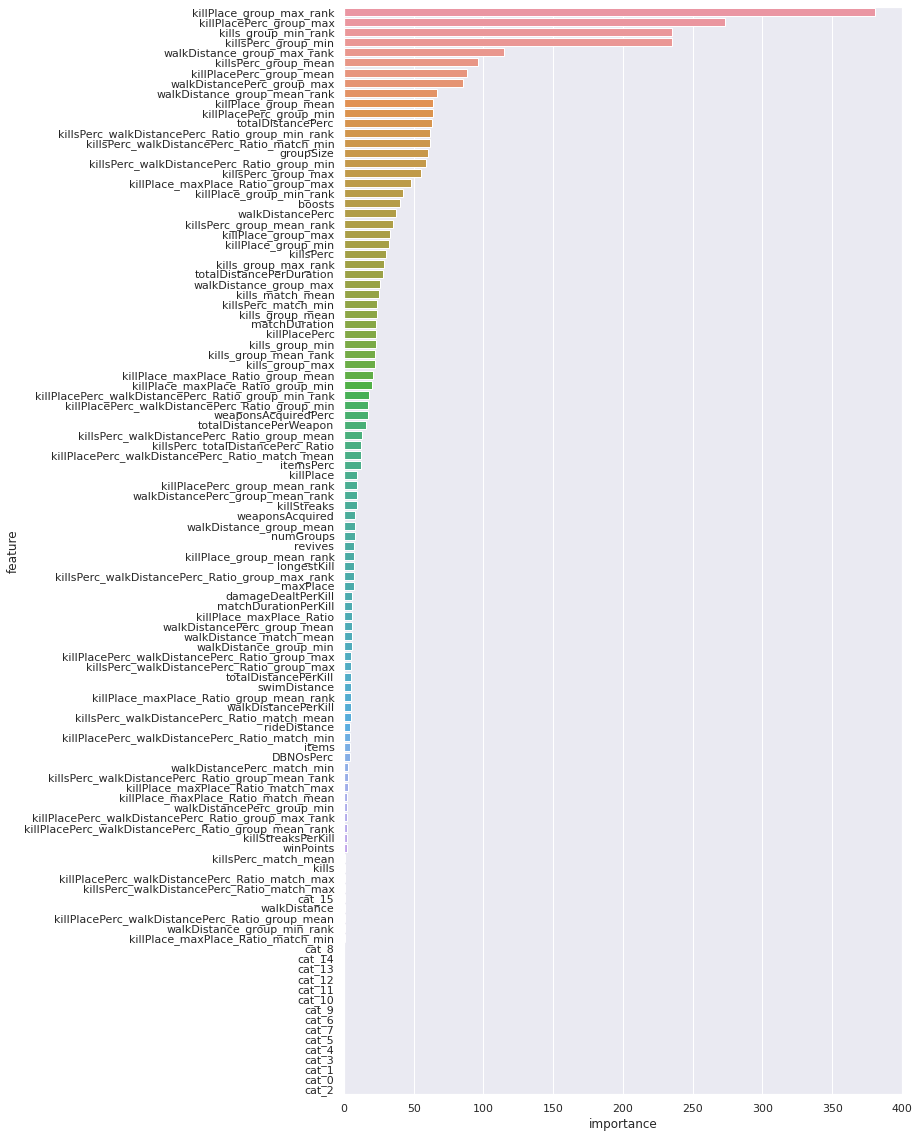

In [ ]:
importances = list(zip(columns, model2.feature_importances_))

df = pd.DataFrame(importances, columns=['feature', 'importance'])
df = df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=df, x='importance', y='feature')
plt.show()

In [ ]:
df.loc[df['importance'] == 0, 'feature'].values

array(['cat_8', 'cat_14', 'cat_13', 'cat_12', 'cat_11', 'cat_10', 'cat_9',
       'cat_6', 'cat_7', 'cat_5', 'cat_4', 'cat_3', 'cat_1', 'cat_0',
       'cat_2'], dtype=object)

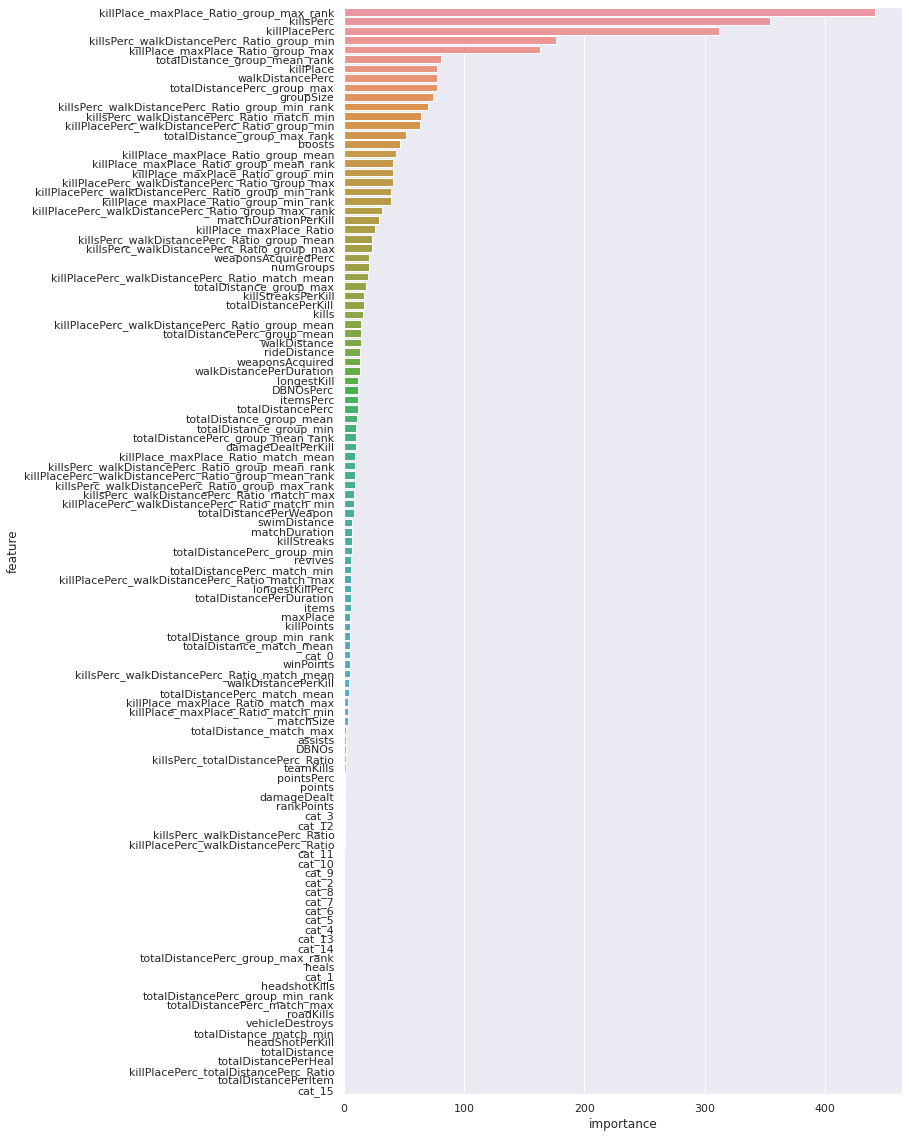

In [ ]:
importances = list(zip(columns, model2.feature_importances_))

df = pd.DataFrame(importances, columns=['feature', 'importance'])
df = df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=df, x='importance', y='feature')
plt.show()

In [ ]:
df.loc[df['importance'] == 0, 'feature'].values

array(['cat_11', 'cat_10', 'cat_9', 'cat_2', 'cat_8', 'cat_7', 'cat_6',
       'cat_5', 'cat_4', 'cat_13', 'cat_14',
       'totalDistancePerc_group_max_rank', 'heals', 'cat_1',
       'headshotKills', 'totalDistancePerc_group_min_rank',
       'totalDistancePerc_match_max', 'roadKills', 'vehicleDestroys',
       'totalDistance_match_min', 'headShotPerKill', 'totalDistance',
       'totalDistancePerHeal', 'killPlacePerc_totalDistancePerc_Ratio',
       'totalDistancePerItem', 'cat_15'], dtype=object)

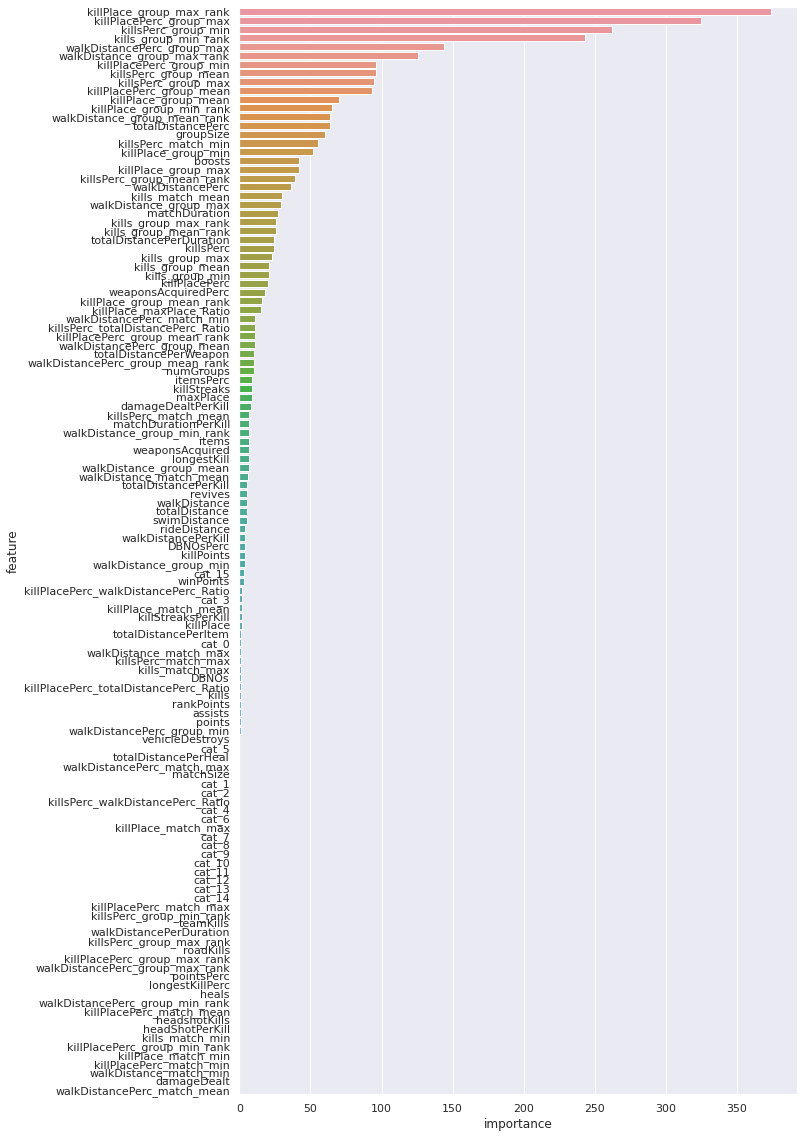

In [ ]:
importances = list(zip(columns, model2.feature_importances_))

df = pd.DataFrame(importances, columns=['feature', 'importance'])
df = df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 20))
sns.barplot(data=df, x='importance', y='feature')
plt.show()

In [ ]:
df.loc[df['importance'] == 0, 'feature'].values

array(['vehicleDestroys', 'cat_5', 'totalDistancePerHeal',
       'walkDistancePerc_match_max', 'matchSize', 'cat_1', 'cat_2',
       'killsPerc_walkDistancePerc_Ratio', 'cat_4', 'cat_6',
       'killPlace_match_max', 'cat_7', 'cat_8', 'cat_9', 'cat_10',
       'cat_11', 'cat_12', 'cat_13', 'cat_14', 'killPlacePerc_match_max',
       'killsPerc_group_min_rank', 'teamKills', 'walkDistancePerDuration',
       'killsPerc_group_max_rank', 'roadKills',
       'killPlacePerc_group_max_rank', 'walkDistancePerc_group_max_rank',
       'pointsPerc', 'longestKillPerc', 'heals',
       'walkDistancePerc_group_min_rank', 'killPlacePerc_match_mean',
       'headshotKills', 'headShotPerKill', 'kills_match_min',
       'killPlacePerc_group_min_rank', 'killPlace_match_min',
       'killPlacePerc_match_min', 'walkDistance_match_min', 'damageDealt',
       'walkDistancePerc_match_mean'], dtype=object)

#### LogisticRegression

우승이냐 아니냐의 2진 분류 문제로 정의한다.

In [ ]:
y_train_bin = y_train.apply(lambda x: 1 if x >= 0.5 else 0)
y_train_bin

528661     1
1922975    1
1736903    0
2846872    0
4290034    0
          ..
3884327    0
298528     0
3186535    0
2383065    0
2758260    0
Name: winPlacePerc, Length: 3112875, dtype: int64

In [ ]:
model3.fit(X_train, y_train_bin)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

#### XGBRegressor

In [ ]:
model4.fit(X_train, y_train)

[10:02:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## 예측 및 성능 평가

### MAE

Kaggle 대회의 평가는 **MAE (Mean Absolute Error)** 값을 기준으로 한다.

In [ ]:
from sklearn.metrics import mean_absolute_error

#### LinearRegression

In [ ]:
print('{:.6f}'.format(mean_absolute_error(y_train, model1.predict(X_train))))
print('{:.6f}'.format(mean_absolute_error(y_test, model1.predict(X_test))))

0.042305
0.042337


#### LGBMRegressor

In [ ]:
print('{:.6f}'.format(mean_absolute_error(y_train, model2.predict(X_train))))
print('{:.6f}'.format(mean_absolute_error(y_test, model2.predict(X_test))))

0.028633
0.028691


#### LogisticRegression

In [ ]:
y_test_bin = y_test.apply(lambda x: 1 if x >= 0.5 else 0)

In [ ]:
print('{:.6f}'.format(mean_absolute_error(y_train_bin, model3.predict(X_train))))
print('{:.6f}'.format(mean_absolute_error(y_test_bin, model3.predict(X_test))))

0.031844
0.031822


#### XGBRegressor

In [ ]:
print('{:.6f}'.format(mean_absolute_error(y_train, model4.predict(X_train))))
print('{:.6f}'.format(mean_absolute_error(y_test, model4.predict(X_test))))

0.069433
0.069423


### 교차검증을 통한 과적합 테스트

https://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(model2, X_train, y_train, scoring='neg_mean_absolute_error', cv=10)

In [ ]:
scores

array([-0.02871877, -0.0286681 , -0.02872528, -0.02877641, -0.02848491,
       -0.02863347, -0.02862833, -0.02867335, -0.02865404, -0.02862517])

In [ ]:
np.mean(-scores)

0.028658784577645348

In [ ]:
mean_absolute_error(y_test, model2.predict(X_test))

NotFittedError: ignored

## 모델 세부 튜닝

### PCA + LGBM Pipeline

해당 작업은 오래걸리므로 일부를 추출한 샘플로 진행할 것을 권장한다.

In [ ]:
from sklearn.utils import resample

X_sample, y_sample = resample(X_train, y_train, n_samples=100000)
X_sample.shape, y_sample.shape

((100000, 108), (100000,))

추출된 샘플이 편향되지 않았는지 검사  
정확도가 많이 떨이지는 이유는 제대로 된 매치 및 그룹이 맞게 떨어지는 데이터가 아니기 때문

In [ ]:
model = LinearRegression()
model.fit(X_sample, y_sample)
print('{:.6f}'.format(mean_absolute_error(y_sample, model.predict(X_sample))))

0.042159


In [ ]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

search_pipeline = Pipeline([
    # ('pca', PCA()),
    ('lgb', LGBMRegressor()),
])

columns_size = X_sample.shape[1]

param_grid = [
    {
        # 'pca__n_components': np.arange(1, columns_size, 1),
        # 'lgb__n_estimators': [100, 200],
        'lgb__n_estimators': [200],
        'lgb__num_leaves': [10, 20, 30, 40, 50, 100, columns_size, 200, 300, 500, 1000],
        # 'lgb__max_depth': [-1, 7, 9],
        'lgb__max_depth': [-1],
        # 'lgb__learning_rate': [0.3, 0.1, 0.03, 0.01],
        'lgb__learning_rate': [0.1],
        'lgb__objective': ['regression_l2'],
    },
]

grid_search = GridSearchCV(search_pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)

In [ ]:
del X_train, y_train
gc.collect()

88

#### PCA

- 112 -> 60
- 108 -> 49

In [ ]:
grid_search.fit(X_sample, y_sample)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:195: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  warnings.warn("Usage of np.ndarray subset (sliced data) is not recommended "


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lgb', LGBMRegressor())]),
             param_grid=[{'pca__n_components': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107])}],
             scoring='neg_mean_absolute_error')

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('pca', PCA(n_components=49)), ('lgb', LGBMRegressor())])

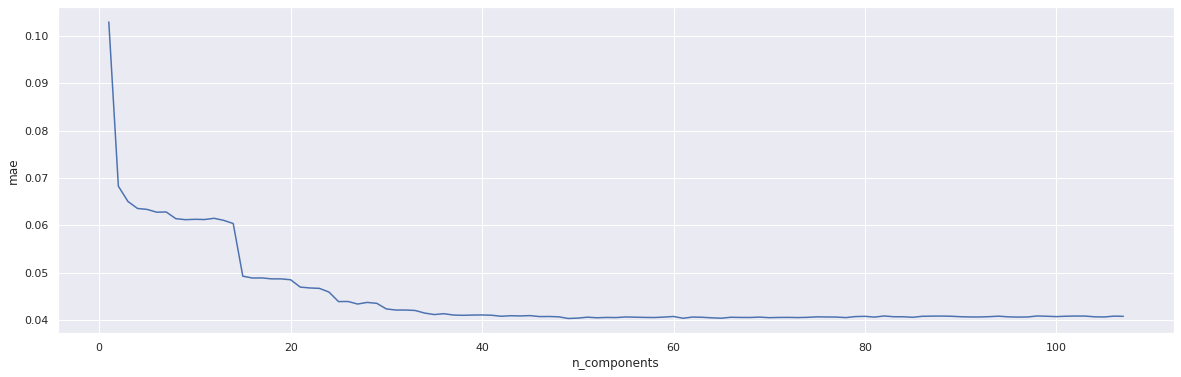

In [ ]:
results = grid_search.cv_results_
results = [(params['pca__n_components'], -mae) for mae, params in zip(results['mean_test_score'], results['params'])]

df = pd.DataFrame(results, columns=['n_components', 'mae'])

plt.figure(figsize=(20, 6))
sns.lineplot(data=df, y='mae', x='n_components')
plt.show()

#### LGBM parameters

In [ ]:
grid_search.fit(X_sample, y_sample)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('lgb', LGBMRegressor())]),
             param_grid=[{'lgb__learning_rate': [0.1], 'lgb__max_depth': [-1],
                          'lgb__n_estimators': [200],
                          'lgb__num_leaves': [10, 20, 30, 40, 50, 100, 108, 200,
                                              300, 500, 1000],
                          'lgb__objective': ['regression_l2']}],
             scoring='neg_mean_absolute_error')

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('lgb',
                 LGBMRegressor(n_estimators=200, num_leaves=500,
                               objective='regression_l2'))])

In [ ]:
results = grid_search.cv_results_
results = [(-mae, params) for mae, params in zip(results['mean_test_score'], results['params'])]
results.sort(key=lambda x: x[0])
results[:10]

[(0.026258517013074755,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 500,
   'lgb__objective': 'regression_l2'}),
 (0.0262628790518191,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 300,
   'lgb__objective': 'regression_l2'}),
 (0.026326694326344536,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 200,
   'lgb__objective': 'regression_l2'}),
 (0.02642086115230687,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 1000,
   'lgb__objective': 'regression_l2'}),
 (0.026632335122625,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 108,
   'lgb__objective': 'regression_l2'}),
 (0.026689269370258034,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 

In [ ]:
grid_search.fit(X_sample, y_sample)

GridSearchCV(cv=3, estimator=Pipeline(steps=[('lgb', LGBMRegressor())]),
             param_grid=[{'lgb__learning_rate': [0.3, 0.1, 0.03, 0.01],
                          'lgb__max_depth': [-1, 7, 9],
                          'lgb__n_estimators': [100, 200],
                          'lgb__num_leaves': [20, 31, 40, 50, 100, 108],
                          'lgb__objective': ['regression_l2']}],
             scoring='neg_mean_absolute_error')

In [ ]:
grid_search.best_params_

{'lgb__learning_rate': 0.1,
 'lgb__max_depth': -1,
 'lgb__n_estimators': 200,
 'lgb__num_leaves': 40,
 'lgb__objective': 'regression_l2'}

In [ ]:
grid_search.best_estimator_

Pipeline(steps=[('lgb',
                 LGBMRegressor(n_estimators=200, num_leaves=40,
                               objective='regression_l2'))])

In [ ]:
results = grid_search.cv_results_
results = [(-mae, params) for mae, params in zip(results['mean_test_score'], results['params'])]
results.sort(key=lambda x: x[0])
results[:10]

[(0.03137530429665155,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 40,
   'lgb__objective': 'regression_l2'}),
 (0.03139865265188834,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': 7,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 108,
   'lgb__objective': 'regression_l2'}),
 (0.03142052985015138,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': 9,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 40,
   'lgb__objective': 'regression_l2'}),
 (0.03144629473187607,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': 7,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 50,
   'lgb__objective': 'regression_l2'}),
 (0.0315063409896688,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': -1,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 50,
   'lgb__objective': 'regression_l2'}),
 (0.03152589929747837,
  {'lgb__learning_rate': 0.1,
   'lgb__max_depth': 7,
   'lgb__n_estimators': 200,
   'lgb__num_leaves': 100,
   'l

#### 최종

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor

class LGBMRegressor2(BaseEstimator, TransformerMixin):
  def __init__(self, **kwargs):
    self.model = LGBMRegressor(**kwargs)
  def fit(self, X, y=None):
    return model.fit(X, y)
  def transform(self, X, y=None):
    return self

full_pipeline = FeatureUnion(transformer_list=[
    # ('convert', convert_pipeline),
    ('pca', PCA(n_components=49)),
    ('lgb', LGBMRegressor2(learning_rate=0.1, n_estimators=200, num_leaves=40)),
])

`fit_inverse_transform` 파라미터를 통해 재구성 원상 오차 계산이 가능함

In [ ]:
full_pipeline.fit_transform(X_train, y_train)

In [ ]:
full_pipeline

메모리 초과로 진행이 안되는 관계로 단계별 진행

## Kaggle 테스트 데이터 예측

위에서 한 전처리(파이프라인)를 동일하게 적용시킨다.

In [ ]:
test = pd.read_csv(TEST_PATH)
test = reduce_mem_usage(test)

print(test.shape)

Memory usage of dataframe is 413.18 MB --> 140.19 MB (Decreased by 66.1%)
(1934174, 28)


In [ ]:
test.head()

Id         groupId         matchId  assists  boosts  \
0  9329eb41e215eb  676b23c24e70d6  45b576ab7daa7f        0       0   
1  639bd0dcd7bda8  430933124148dd  42a9a0b906c928        0       4   
2  63d5c8ef8dfe91  0b45f5db20ba99  87e7e4477a048e        1       0   
3  cf5b81422591d1  b7497dbdc77f4a  1b9a94f1af67f1        0       0   
4  ee6a295187ba21  6604ce20a1d230  40754a93016066        0       4   

   damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  kills  \
0       51.460      0              0      0         73           0      0   
1      179.100      0              0      2         11           0      2   
2       23.400      0              0      4         49           0      0   
3       65.520      0              0      0         54           0      0   
4      330.200      1              2      1          7           0      3   

   killStreaks  longestKill  matchDuration  matchType  maxPlace  numGroups  \
0            0        0.000           1884  squad-fpp        28         28   
1            1      361.900           1811    duo-fpp        48         47   
2            0        0.000           1793  squad-fpp        28         27   
3            0        0.000           1834    duo-fpp        45         44   
4            1       60.060           1326  squad-fpp        28         27   

   rankPoints  revives  rideDistance  roadKills  swimDistance  teamKills  \
0        1500        0         0.000          0         0.000          0   
1        1503        2      4669.000          0         0.000          0   
2        1565        0         0.000          0         0.000          0   
3        1465        0         0.000          0         0.000          0   
4        1480        1         0.000          0         0.000          0   

   vehicleDestroys  walkDistance  weaponsAcquired  winPoints  
0                0       588.000                1          0  
1                0      2017.000                6          0  
2                0       787.800                4          0  
3                0      1812.000                3          0  
4                0      2963.000                4          0

### 제출 코드

In [ ]:
import numpy as np
import pandas as pd
import gc
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor


DATASET_ROOT = '/content/drive/MyDrive/Project/Modeling/pubg-finish-placement-prediction'
TRAIN_PATH = DATASET_ROOT + '/train_V2.csv'
TEST_PATH = DATASET_ROOT + '/test_V2.csv'

features = [
  'kills', 'killsPerc',
  'killPlace', 'killPlacePerc', 
  'walkDistance', 'walkDistancePerc',
  # 'totalDistance', 'totalDistancePerc',
  'killPlace_maxPlace_Ratio', 
  'killsPerc_walkDistancePerc_Ratio',
  'killPlacePerc_walkDistancePerc_Ratio',
]


def reduce_mem_usage(df):
  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()
      
      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
          df[col] = df[col].astype(np.int8)
        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)  
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        else:
          df[col] = df[col].astype(np.float64)

  return df


def preprocess_point(df):
  df.loc[(df['rankPoints'] < 0), 'rankPoints'] = 0
  df.loc[(df['killPoints'] < 0), 'killPoints'] = 0

  df['points'] = df['rankPoints'] + df['killPoints']

  df['pointsPerc'] = df.groupby('matchId')['points'].rank(pct=True)

  return df


def preprocess_teamplay(df):
  df['DBNOsPerc'] = df.groupby('matchId')['DBNOs'].rank(pct=True)

  return df


def preprocess_kill(df):
  df['killsPerc'] = df.groupby('matchId')['kills'].rank(pct=True)
  df['longestKillPerc'] = df.groupby('matchId')['longestKill'].rank(pct=True)
  df['killPlacePerc'] = df.groupby('matchId')['killPlace'].rank(pct=True)

  df['killStreaksPerKill'] = df['killStreaks'] / df['kills']
  df['headShotPerKill'] = df['headshotKills'] / df['kills']
  df['damageDealtPerKill'] = df['damageDealt'] / df['kills']
  df['matchDurationPerKill'] = df['matchDuration'] / df['kills']

  df['killPlace_maxPlace_Ratio'] = df['killPlace'] / df['maxPlace']
  
  return df


def preprocess_distance(df):
  df['totalDistance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']

  df['walkDistancePerc'] = df.groupby('matchId')['walkDistance'].rank(pct=True)
  df['totalDistancePerc'] = df.groupby('matchId')['totalDistance'].rank(pct=True)

  df['totalDistancePerDuration'] = df['totalDistance'] / df['matchDuration']
  df['walkDistancePerDuration'] = df['walkDistance'] / df['matchDuration']
  df['walkDistancePerKill'] = df['walkDistance'] / df['kills']
  df['totalDistancePerKill'] = df['totalDistance'] / df['kills']
  df['totalDistancePerHeal'] = df['totalDistance'] / df['heals']
  
  df['killsPerc_walkDistancePerc_Ratio'] = df['killsPerc'] / df['walkDistancePerc']
  df['killsPerc_totalDistancePerc_Ratio'] = df['killsPerc'] / df['totalDistancePerc']
  df['killPlacePerc_walkDistancePerc_Ratio'] = df['killPlacePerc'] / df['walkDistancePerc']
  df['killPlacePerc_totalDistancePerc_Ratio'] = df['killPlacePerc'] / df['totalDistancePerc']

  return df


def preprocess_item(df):
  df['items'] = df['boosts'] + df['heals']

  df['itemsPerc'] = df.groupby('matchId')['items'].rank(pct=True)
  df['weaponsAcquiredPerc'] = df.groupby('matchId')['weaponsAcquired'].rank(pct=True)

  df['totalDistancePerItem'] = df['totalDistance'] / df['items']
  df['totalDistancePerWeapon'] = df['totalDistance'] / df['weaponsAcquired']

  return df


def preprocess_inf(df):
  df[df == np.Inf] = np.NaN
  df[df == np.NINF] = np.NaN
  df.fillna(0, inplace=True)

  return df


def preprocess_groupby_groupId(df, fn):
  df_group = df.groupby(['matchId', 'groupId'])[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_group_{fn}'], how='left', on=['matchId', 'groupId'])

  df_group_rank = df_group.groupby('matchId')[features].rank(pct=True)
  df = pd.merge(df, df_group_rank, suffixes=['', f'_group_{fn}_rank'], how='left', on=['matchId', 'groupId'])

  del df_group
  del df_group_rank
  gc.collect()

  return df


def preprocess_group_size(df):
  df_group = df.groupby(['matchId', 'groupId']).size().reset_index(name='groupSize')
  df = pd.merge(df, df_group, how='left', on=['matchId', 'groupId'])

  del df_group
  gc.collect()

  return df


def preprocess_groupby_matchId(df, fn):
  df_group = df.groupby(['matchId'])[features].agg(fn)
  df = pd.merge(df, df_group, suffixes=['', f'_match_{fn}'], how='left', on=['matchId'])

  del df_group
  gc.collect()

  return df


def preprocess_match_size(df):
  df_group = df.groupby(['matchId']).size().reset_index(name='matchSize')
  df = pd.merge(df, df_group, how='left', on=['matchId'])

  del df_group
  gc.collect()

  return df


def preprocess_data(isTrain=True):
  df = pd.read_csv(TRAIN_PATH if isTrain else TEST_PATH)
  df = reduce_mem_usage(df)
  
  df = preprocess_point(df)
  df = preprocess_teamplay(df)
  df = preprocess_kill(df)
  df = preprocess_distance(df)
  df = preprocess_item(df)
  df = preprocess_inf(df)
  df = reduce_mem_usage(df)

  df = preprocess_groupby_groupId(df, 'mean')
  df = preprocess_groupby_groupId(df, 'min')
  df = preprocess_groupby_groupId(df, 'max')
  df = preprocess_group_size(df)
  df = reduce_mem_usage(df)

  df = preprocess_groupby_matchId(df, 'mean')
  df = preprocess_groupby_matchId(df, 'min')
  df = preprocess_groupby_matchId(df, 'max')
  df = preprocess_match_size(df)
  df = reduce_mem_usage(df)

  except_attribs = [
    'Id', 'groupId', 'matchId',

    'matchType',
    'winPlacePerc',

    'DBNOs',
    'assists',
    'cat_0',
    'cat_1',
    'cat_10',
    'cat_11',
    'cat_12',
    'cat_13',
    'cat_14',
    'cat_15',
    'cat_2',
    'cat_3',
    'cat_4',
    'cat_5',
    'cat_6',
    'cat_7',
    'cat_8',
    'cat_9',
    'damageDealt',
    'headShotPerKill',
    'headshotKills',
    'heals',
    'killPlacePerc_group_max_rank',
    'killPlacePerc_group_min_rank',
    'killPlacePerc_match_max',
    'killPlacePerc_match_mean',
    'killPlacePerc_match_min',
    'killPlacePerc_totalDistancePerc_Ratio',
    'killPlacePerc_walkDistancePerc_Ratio',
    'killPlace_match_max',
    'killPlace_match_mean',
    'killPlace_match_min',
    'killPlace_maxPlace_Ratio_group_max_rank',
    'killPlace_maxPlace_Ratio_group_min_rank',
    'killPoints',
    'killsPerc_group_max_rank',
    'killsPerc_group_min_rank',
    'killsPerc_match_max',
    'killsPerc_walkDistancePerc_Ratio',
    'kills_match_max',
    'kills_match_min',
    'longestKillPerc',
    'matchSize',
    'points',
    'pointsPerc',
    'rankPoints',
    'roadKills',
    'teamKills',
    'totalDistance',
    'totalDistancePerHeal',
    'totalDistancePerItem',
    'totalDistancePerc_group_max_rank',
    'totalDistancePerc_group_min_rank',
    'totalDistancePerc_match_max',
    'totalDistance_match_min',
    'vehicleDestroys',
    'walkDistancePerDuration',
    'walkDistancePerc_group_max_rank',
    'walkDistancePerc_group_min_rank',
    'walkDistancePerc_match_max',
    'walkDistancePerc_match_mean',
    'walkDistance_match_max',
    'walkDistance_match_min',
  ]

  y = df['winPlacePerc'] if isTrain else None
  Id = None if isTrain else df[['Id']] # to dataframe

  attribs = list(df.columns)

  for attrib in except_attribs:
    if attrib in attribs:
      df.drop(attrib, axis=1, inplace=True)

  df = reduce_mem_usage(df)

  return df, y, Id


def main():
  X_train, y_train, _ = preprocess_data() # train load

  model = LGBMRegressor(
      n_estimators=200,
      # num_leaves=100,
  )
  model.fit(X_train, y_train)

  print('{:.6f}'.format(mean_absolute_error(y_train, model.predict(X_train))))

  del X_train
  del y_train
  gc.collect()

  # X_test, _, X_Id = preprocess_data(False) # test load

  # # save submission
  # submission = X_Id.copy()
  # submission['winPlacePerc'] = model.predict(X_test)
  # submission.to_csv('submission.csv', index=False)


main()

0.026857


MAE: 0.024937

In [ ]:
df = pd.read_csv('submission.csv')

In [ ]:
df

Id  winPlacePerc
0        9329eb41e215eb      0.188403
1        639bd0dcd7bda8      0.942360
2        63d5c8ef8dfe91      0.871803
3        cf5b81422591d1      0.502721
4        ee6a295187ba21      0.959880
...                 ...           ...
1934169  a316c3a13887d5      0.803037
1934170  5312146b27d875      0.377250
1934171  fc8818b5b32ad3      0.891261
1934172  a0f91e35f8458f      0.815614
1934173  3696fc9f3a42b2      0.040441

[1934174 rows x 2 columns]

https://www.kaggle.com/code/esxmod/notebookac21ee6192  
MAE: 0.02546

## 결론

    [문제 정의 및 가설]

    초기 가설을 설정할 때 다소 많은 가설을 세운 것에 대해서는  
    오히려 필요성을 따져 확실한 근거에 기반한 가설들만을 남기는 것이 중요하다고 판단되었다.

    그리고 이들을 뒷 받침할 만한 참고 자료, 문헌들의 필요성을 느꼈고
    현재로서는 도메인 지식이 부족했던 탓에 모호한 결론만이 남은 점이 아쉬웠다.
    

    [EDA]
    분석을 진행하는 과정에서 두 특성간의 관계가 나타나 보이지 않는 요소들은  
    범주형으로 처리한 경우에 비로소 관계가 나타나는 경우가 존재했다.

    또한 한가지 가설 및 일부 컬럼만을 집중 분석한것 만으로는  
    모델의 정확도 및 성능을 끌어올리기에는 터무니없이 부족했다.

    그 예가 내가 선택한 가설의 대상인 레이트 지표다.

    뒤늦게 안 사실이지만 매치 내 그룹별로 묶어 상대적인 지표를 활용해야
    비로소 정확한 예측이 가능하다는 점은 배틀그라운드에 대한 도메인 지식이 없다면 이해하기 어려운 부분이었다.


    [모델링]
    처음에는 간단한 스케일링 및 인코딩만 거친 후 모든 피처를 대상으로  
    PCA (차원축소) 및 하이퍼 파라미터 탐색을 통해 최적의 LGBM 모델을 구해보았다.

    그러나 의외로 기본 파라미터 상태일 때 MAE 값이 가장 낮게 나왔다.  
    (이후 좀 더 범위를 넓게하여 재탐색 해본 결과 learning_rate 및 n_estimators 가 다른 경우 미세하게 좀 더 낮게 나오기는 했다)

    이는 결국 데이터 전처리가 필수 불가결함을 의미했고, 즉 EDA 의 중요성을 다시금 상기시키게 해주었다.

    또한 대용량 데이터들을 대상으로 매 탐색에 대한 결과를 확인해보려면 상당한 시간이 소모된다.  
    그러므로 빠른 학습 진행을 하기 위해 일부 샘플링 추출을 통하여 진행해보는 것이 효율적일 것이라 판단되었다.


    [배포]
    대부분을 EDA 및 모델링에 초점을 맞춰 프로젝트를 진행함으로서
    향후 이 내용을 기반으로 한 파이썬 프로젝트(.py)를 작성해볼 기회가 없었던 점이 아쉬웠다.

    대신 해당 파일 내에서라도 가급적이면 반복되는 내용을 줄임으로서 기능을 함수별로 묶어 모듈화를 시도해보았고  
    파이프라인을 통해 반복되는 작업을 최대한 효율적으로 진행할 수 있도록 구성해 보았다.
    
    

    

